# FermionicML:

Basado en aguschanchu/RhoGC. Permite utilizar nuevas bases, es más simple y mejor optimizado. Basado en matrices sparse

In [2]:
!pip install openfermion sparse ray

In [113]:
import numpy as np
import openfermion as of
from tqdm import tqdm
from itertools import combinations
from openfermion.utils import commutator, count_qubits, hermitian_conjugated
import functools
import concurrent.futures
from numba import njit
import tensorflow as tf
import scipy
import sparse
import itertools

# Generación de base
class fixed_basis:
    @staticmethod
    def int_to_bin(k, d):
        return np.base_repr(k, 2).zfill(d)

    @staticmethod
    def bin_to_op(b):
        tups = [(i, 1) for i, k in list(enumerate(list(b))) if k == '1']
        return of.FermionOperator(tups)

    def idx_to_repr(self, idx):
        return self.canonicals[idx]

    def opr_to_idx(self, opr):
        return self.base.index(opr)

    # Calcula el valor medio a partir del indice del vector y el operador
    def idx_mean_val(self, idx: int, op: of.FermionOperator):
        vec = self.idx_to_repr(idx)
        return np.real(np.transpose(vec) @ of.get_sparse_operator(op, n_qubits=self.d) @ vec)

    # Calcula el valor medio a partir de un estado y el operador
    def mean_val(self, vec, op):
        idx = self.opr_to_idx(vec)
        return self.idx_mean_val(idx, op)

    # Calcula la contracción de un operador sobre dos estados dados
    def idx_contraction(self, idx_1, idx_2, op):
        rep = lambda x: self.idx_to_repr(x)
        return np.real(np.transpose(rep(idx_1)) @ of.get_sparse_operator(op, n_qubits=self.d) @ rep(idx_2))

    def create_basis(self, d, num = None, pairs = False):
        basis = []
        num_ele = []
        for k in range(0,2**d):
            b = self.int_to_bin(k, d)
            if num != None:
                if b.count('1') == num:
                    if pairs:
                        if np.all(b[::2] == b[1::2]):
                            oper = self.bin_to_op(b)
                            basis.append(oper)
                            num_ele.append(k)
                    else:
                        oper = self.bin_to_op(b)
                        basis.append(oper)
                        num_ele.append(k)
            else:
                oper = self.bin_to_op(b)
                basis.append(oper)
        return basis, num_ele

    def __init__(self, d, num = None, pairs = False):
        self.d = d
        self.num = num
        self.m = num
        self.base, self.num_ele = self.create_basis(d, num, pairs)
        self.size = len(self.base)
        self.canonicals = np.eye(self.size)
        self.pairs = pairs

    @staticmethod
    def cdc(i, j):
        return of.FermionOperator(((i,1),(j,0)))

    @staticmethod
    def cc(i, j):
        return of.FermionOperator(((i,0),(j,0)))

    # Del indice, cuenta el número de partículas
    def num_idx(self, idx):
        b = self.int_to_bin(idx, basis.d)
        return b.count('1')

    # Calculo de rho1 (via directa, lento, y solo definido en la base por ahora)
    def rho_1(self, op):
        # Necesitamos un índice, es?
        if type(op) != int:
            op = self.opr_to_idx(op)
        mat = np.zeros((self.d, self.d))
        for i in range(self.d):
            for j in range(self.d):
                cdc = self.cdc(j, i)
                mat[i,j] = self.idx_mean_val(op, cdc)
        return mat

# Calculo de generadores de rho1
def rho_1_gen(basis):
    # Vamos a crear un hipersparse de TF, almacenamos los valores acá
    indices = []
    values = []
    shape = (basis.d, basis.d, basis.size, basis.size)
    d = basis.d
    for i in tqdm(range(0, d)):
        for j in range(0, d):
            # Generamos el operador
            op = basis.cdc(j, i)
            if basis.num == None:
                mat = np.real(of.get_sparse_operator(op, n_qubits=d))
            else:
                mat = np.real(of.get_sparse_operator(op, n_qubits=d))[np.ix_(basis.num_ele, basis.num_ele)]
            # Extraemos la información
            n_r, n_c = mat.nonzero()
            data = mat.data
            for r, c, v in zip(n_r, n_c, data):
                indices.append([i, j, r, c])
                values.append(v)
    indices_t = np.array(indices).T
    s_t = sparse.COO(indices_t, values, shape=shape)
    return s_t

# Calculo de rho1 (via generadores) de un vector en la base canonica
def rho_1(vect, rho_1_arrays):
    if len(vect.shape) == 1: # vectores
        return sparse.einsum('k,ijkl,l->ij', vect, rho_1_arrays, vect)
    elif len(vect.shape) == 2: # mat densidad
        return sparse.einsum('ijkl,kl->ij', rho_1_arrays, vect)
    else: # mat densidad batcheadas
        return sparse.einsum('bkl,ijkl->bij', vect, rho_1_arrays)

# Calculo de indices de rho2kkbar
def get_kkbar_indices(t_basis):
    indices = []
    for i, ind in enumerate(t_basis.num_ele):
        v = t_basis.int_to_bin(ind, t_basis.d)
        if np.all(v[::2] == v[1::2]):
            indices.append(i)
    return indices

# Calculo de generadores de rho2
def rho_2_gen(basis, t_basis, kkbar = False):
    # Vamos a crear un hipersparse de TF, almacenamos los valores acá
    indices = []
    values = []
    if kkbar:
        idx_list = get_kkbar_indices(t_basis)
    else:
        idx_list = range(t_basis.size)
    shape = (len(idx_list), len(idx_list), basis.size, basis.size)
    for i, ii in tqdm(enumerate(idx_list), total=len(idx_list)):
        for j, jj in enumerate(idx_list):
            # Generamos el operador
            op = t_basis.base[jj]*of.utils.hermitian_conjugated(t_basis.base[ii])
            if basis.num == None:
                mat = np.real(of.get_sparse_operator(op, n_qubits=d))
            else:
                mat = np.real(of.get_sparse_operator(op, n_qubits=d))[np.ix_(basis.num_ele, basis.num_ele)]
            # Extraemos la información
            n_r, n_c = mat.nonzero()
            data = mat.data
            for r, c, v in zip(n_r, n_c, data):
                indices.append([i, j, r, c])
                values.append(v)

    indices_t = np.array(indices).T
    s_t = sparse.COO(indices_t, values, shape=shape)
    return s_t

# A partir de rho_2_arrays, toma el bloque c^d_i c^d_{/bar{j}} c_{/bar{k}} c_l
def rho_2_block_gen(basis, rho_2_arrays):
    # Generamos los operadores
    ops = []
    for i, j, k, l in itertools.product(range(basis.m), repeat=4):
        op = of.FermionOperator(((2 * i, 1), (2 * j + 1, 1), (2 * k + 1, 0), (2 * l, 0)))
        sparse_op = of.get_sparse_operator(op, n_qubits=basis.d)[np.ix_(basis.num_ele, basis.num_ele)]
        ops.append(sparse_op)

    # Seleccionamos el conjunto de índices en t_basis (alpha, alpha')
    res = []
    for idx in range(len(ops)):
        matches = np.all(rho_2_arrays == ops[idx], axis=[2,3])
        matching_indices = np.where(matches.todense())
        res.extend(list(zip(matching_indices[0], matching_indices[1])))

    return res

# Calculo de rho2 (via generadores) de un estado en la base canonica
def rho_2(vect, rho_2_arrays):
    if len(vect.shape) == 1: # vectores
        return sparse.einsum('k,ijkl,l->ij', vect, rho_2_arrays, vect)
    elif len(vect.shape) == 2: # mat densidad
        return sparse.einsum('ijkl,kl->ij', rho_2_arrays, vect)
    else: # mat densidad batcheadas
        return sparse.einsum('bkl,ijkl->bij', vect, rho_2_arrays)

# Calculo de generadores de K (usado para quasiparticles) WIP SPARSE
def k_gen(basis):
    mat = np.zeros((basis.d, basis.d, basis.size, basis.size))
    d = basis.d
    for i in tqdm(range(0, d), total=d):
        for j in range(0, d):
            op = basis.cc(j, i)
            if basis.num == None:
                mat[i,j,::] = np.real(of.get_sparse_operator(op, n_qubits=d)).todense()
            else:
                mat[i,j,::] = np.real(of.get_sparse_operator(op, n_qubits=d)).todense()[np.ix_(basis.num_ele, basis.num_ele)]
    return mat

def k_vect(vect, k_gen):
    return np.einsum('k,ijkl,l->ij', vect, k_gen, vect)

# Calculo la matrix rho de cuasipartículas  WIP SPARSE
def rho_qsp(vect, rho_1_arrays, k_arrays, rho1 = None):
    if type(rho1) == None:
        rho1 = rho_1(vect, rho_1_arrays)
    k = k_vect(vect, k_arrays)

    mat = np.block([[rho1, k], [-np.conjugate(k), np.eye(rho_1_arrays.shape[0])-np.conjugate(rho1)]])
    return mat

# Devuelve los indices que tienen a level ocupado
def level_proy(d, level):
    ids = []
    for k in range(0,2**d):
        b = fixed_basis.int_to_bin(k, d)
        if b[level] == '1':
            ids.append(k)
    arr = np.zeros(2**d)
    arr[np.array(ids)] = 1
    return arr, ids

def parity_levels(d):
    rng = range(2**d)
    binary_repr = np.vectorize(np.binary_repr)(rng)
    ones_c = np.char.count(binary_repr, '1')
    return np.array(rng)[ones_c % 2 == 1] # seleccionamos estados impares

# Devuelve el vector postmedido
def measure(basis, vect, level = 1):
    l_arr, l_ids = level_proy(basis.d, level)
    proy_v = vect * l_arr
    comp_arr = np.logical_not(l_arr).astype(int)
    comp_v = vect * comp_arr
    norm = lambda v: v / np.linalg.norm(v)
    return norm(proy_v), norm(comp_v)

## Definicion de Hamiltoniano

Configuramos, y creamos los arrays pertinentes

In [81]:
d = 4
num = d//2 # En caso de ser None, es GC
pairs = False

# Bases
basis = fixed_basis(d, num=num, pairs=pairs)
t_basis = fixed_basis(d, num=2, pairs=pairs)
# Arrays
rho_1_arrays = rho_1_gen(basis)
rho_2_arrays = rho_2_gen(basis, t_basis)
rho_2_kkbar_arrays = rho_2_gen(basis, t_basis, kkbar = True)
k_indices = get_kkbar_indices(t_basis)
print(basis.size, t_basis.size)
print(k_indices)

100%|██████████| 2/2 [00:00<00:00, 61.72it/s]

6 6
[0, 5]


In [4]:
def two_body_hamiltonian_sp(energy_seed, G_batched, rho_1_arrays, rho_2_arrays, indices = None):
    # SECCIÓN ENERGIAS
    ## Dado un seed de niveles diagonal construimos la mat simétrica dxd que multiplicara a c^dag_i c_j
    diagonal = np.zeros((gpu_batch_size, basis.d, basis.d))
    diagonal[:, np.arange(basis.d), np.arange(basis.d)] = energy_seed
    ## Convertimos en sparse la energia y la expandimos
    energy_matrix = sparse.COO.from_numpy(diagonal)
    energy_matrix_expanded = energy_matrix[:, :, :, np.newaxis, np.newaxis]
    rho_1_gen_transposed = rho_1_arrays.transpose(axes=[1, 0, 2, 3])
    # Multiplicamos por los operadores C^dag C
    matprod = energy_matrix_expanded * rho_1_gen_transposed[np.newaxis,:,:,:,:]
    h0_arr = matprod.sum(axis=[1,2])

    # SECCIÓN INTERACCIÓN
    # Ya tenemos los indices de updates, ahora tomamos la mat en t_basis (una de zeros)
    # y updateamos de acuerdo a la lista de G's cada uno flatteneados

    # Creamos la mat de t_basis, nada más que hacer! los coeficientes están dados. Bueno, y simetrizar
    int_mat = np.zeros((gpu_batch_size, t_basis.size, t_basis.size))

    # Si nos dieron indices, debemos llevar el G_arr (d,d) -> (t_basis.size, t_basis.size)
    if indices != None:
        indices = np.array(indices)
        int_mat[:, indices[:, None], indices[None, :]] = G_batched
    else:
        idx = np.triu_indices(t_basis.size)
        int_mat[:, idx[0], idx[1]] = G_batched

    diagonal = np.einsum('ijk,ijk->ijk', int_mat, np.eye(t_basis.size)[np.newaxis,::])
    int_mat = int_mat + np.transpose(int_mat, axes=(0,2,1)) - diagonal
    int_mat = sparse.COO.from_numpy(int_mat)

    # Preparamos las dimensiones y multiplicamos
    int_mat_expanded = int_mat[:, :, :, np.newaxis, np.newaxis]
    rho_2_gen_transposed = rho_2_arrays.transpose(axes=[1, 0, 2, 3])
    matprod = int_mat_expanded * rho_2_gen_transposed[np.newaxis,:,:,:,:]
    hi_arr = matprod.sum(axis=[1,2])

    return h0_arr - hi_arr


def state_energy(state, h_arr):
    return tf.linalg.trace(tf.matmul(state, h_arr))


In [5]:
# TEST: Las funciones de TF y comunes coinciden

# Dado h, \beta, construyo el estado térmico
def thermal_state(h):
    quotient = scipy.linalg.expm(-h)
    return quotient / np.trace(quotient, axis1=-1, axis2=-2)[:, np.newaxis, np.newaxis]

## NO usar para mat no hermiticas
def thermal_state_eig(h, beta):
    w, v = np.linalg.eigh(-beta*h)
    D = np.diag(np.exp(w))
    mat = v @ D @ v.T
    mat = mat / np.trace(mat)
    return mat

def gen_to_h(base, rho_1_arrays):
    triag = fill_triangular_np(base)
    body_gen = triag + np.transpose(triag)-np.diag(np.diag(triag))
    h = np.array(base_hamiltonian(body_gen, basis, rho_1_arrays))
    return h

def gen_to_h_1b(hamil_base):
    triag = tfp.math.fill_triangular(hamil_base, upper=True)
    body_gen = triag + tf.transpose(triag, perm=[0,2,1])-tf.linalg.diag(tf.linalg.diag_part(triag))
    return body_gen

def gen_to_h_tf(hamil_base, rho_1_arrays):
    triag = tfp.math.fill_triangular(hamil_base, upper=True)
    body_gen = triag + tf.transpose(triag, perm=[0,2,1])-tf.linalg.diag(tf.linalg.diag_part(triag)) # Simetrizamos y generamos la matriz de h
    hamil_expanded = body_gen[:, :, :, np.newaxis, np.newaxis]
    rho_1_gen_transposed = tf.transpose(rho_1_arrays, perm=[1, 0, 2, 3])
    h_arr = tf.reduce_sum(hamil_expanded * rho_1_gen_transposed[np.newaxis,:,:,:,:], axis=[1,2])
    return h_arr

def thermal_state_tf(h):
    # Assume beta=1
    exp_hamiltonian = tf.linalg.expm(-h)
    partition_function = tf.linalg.trace(exp_hamiltonian)
    partition_function = tf.expand_dims(partition_function, axis=1)
    partition_function = tf.expand_dims(partition_function, axis=1)

    rho = exp_hamiltonian / partition_function

    return rho

def rho_1_tf(state, rho_1_arrays):
    state = tf.expand_dims(state, axis=1)  # Shape: (5120, 10, 1, 10)
    state_expanded = tf.expand_dims(state, axis=1)
    rho_1_arrays_expanded = tf.expand_dims(rho_1_arrays, axis=0)  # Shape: (1, 5, 5, 10, 10)
    product = state_expanded * rho_1_arrays_expanded  # Shape: (5120, 10, 5, 10, 10)
    mat = tf.reduce_sum(product, axis=[-2, -1])  # Shape: (5120, 5, 5)

    return mat

def rho_2_tf(state, rho_2_arrays):
    state = tf.expand_dims(state, axis=1)  # Shape: (5120, 10, 1, 10)
    state_expanded = tf.expand_dims(state, axis=1)
    rho_2_arrays_expanded = tf.expand_dims(rho_2_arrays, axis=0)  # Shape: (1, 5, 5, 10, 10)
    product = state_expanded * rho_2_arrays_expanded  # Shape: (5120, 10, 5, 10, 10)
    mat = tf.reduce_sum(product, axis=[-2, -1])  # Shape: (5120, 5, 5)

    return mat

# NOTA: para calcular el bloque rho2kkbar, utilizar en lugar

def rho_1_gc_tf(hamil_base):
    e, v = tf.linalg.eigh(gen_to_h_1b(hamil_base))
    result = 1 / (1 + tf.exp(e))
    result = tf.linalg.diag(result)
    res = tf.linalg.matmul(v,result)
    res = tf.linalg.matmul(res,v,adjoint_b=True)

    return tf.cast(res, tf.float32)

def pure_state(h):
    mat = np.zeros((gpu_batch_size, basis.size, basis.size))
    for i in range(gpu_batch_size):
        e, v = scipy.sparse.linalg.eigsh(h[i,:,:])
        fund = v[:, 0]
        mat[i,:,:] = np.einsum('i,j->ij', fund.ravel(), fund.ravel())
    return mat

# Casos de entrenamiento tipo mat gaussianas
def gen_gauss_mat(G, sigma_sq, size):
    indices = np.arange(size)
    mat = G * np.exp(-((indices - indices[:, np.newaxis])**2) / (2 * sigma_sq))
    return mat

def gen_gauss_mat_np(G_values, sigma_sq_values, size):
    indices = np.arange(size, dtype=np.float32)
    indices_diff = indices - indices[:, np.newaxis]

    mat = G_values[:, np.newaxis, np.newaxis] * np.exp(-np.square(indices_diff) / (2 * sigma_sq_values[:, np.newaxis, np.newaxis]))

    return mat

# Casos de entrenamiento tipo matriz vectorial
def gen_vect_mat(size, g_init, g_stop, sym = True):
    if sym:
        vect = np.sort(np.random.uniform(g_init, g_stop, size // 2))[::-1]
        vect = np.repeat(vect, 2)
        if size % 2 != 0: # TODO: Agregar tipo en el medio
            raise ValueError
    else:
        vect = np.sort(np.random.uniform(g_init, g_stop, size))[::-1]
    indices = np.abs(np.arange(size)[:, np.newaxis] - np.arange(size))
    mat = vect[indices]

    return vect, mat

def gen_gauss_plus_vect(G_values, sigma_sq_values, size):
    indices = np.arange(size//2, dtype=np.float32)
    vect = G_values[:, np.newaxis] * np.exp(-np.square(indices) / (2 * sigma_sq_values[:, np.newaxis]))
    return vect

def gen_random_arr(h_labels):
    matrices = np.zeros((gpu_batch_size, basis.m, basis.m))
    up_idx = np.triu_indices(basis.m, 1)
    matrices[:, up_idx[0], up_idx[1]] = h_labels
    matrices += matrices.transpose(0, 2, 1)

    return matrices

def random_fermi_arr(g_init, g_stop, s = basis.num):
    # En primer lugar, construimos la mat simétrica con respecto a nivel de Fermi
    seed = np.round(np.random.uniform(g_init, g_stop,(s//2, s//2)), 2)
    mat = np.zeros((s, s))
    for i in range(s):
        for j in range(s):
            conv = lambda x: s//2 - 1 - np.min([x,s-1-x])
            mat[i,j] = seed[conv(i), conv(j)]

    # Simetrizamos
    mat = (mat + mat.T)/2
    # Volamos la diagonal + antidiagonal
    mat = mat - np.diag(np.diag(mat)) - np.diag(np.diag(mat))[::-1]

    # Los labels se buscan de la siguiente manera
    #up_idx = np.triu_indices(basis.m//2, 1)
    #mat[up_idx].reshape((8,8))

def random_fermi_arr_inv(seed, s=basis.num, obj = False):
    up_idx = np.triu_indices(s//2, 1)
    reb = np.zeros((s//2,s//2))
    if obj:
        reb = np.zeros((s//2,s//2), dtype=object)
    reb[up_idx] = seed
    reb = reb + reb.T
    rebsymm = reb[::-1]
    res = np.block([[reb,np.flip(rebsymm)],[rebsymm,np.flip(reb)]])

    return res


## Modelo de ML
Basado en matrices densidad de 1 y 2 cuerpos como input, con hamiltoniano como salida

In [6]:
import tensorflow as tf
import numpy as np
tf.test.gpu_device_name()


2024-10-16 13:23:41.454805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-16 13:23:42.207285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-16 13:23:42.207622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

'/device:GPU:0'

### Construccion de dataset

#### Version sincrónica

In [7]:
import time
from tqdm import tqdm
from typing import Literal
import ray

# Config
#num_samples = 1500
gpu_batch_size = 256 # 256
u_energy_seed = np.array([np.repeat(np.arange(0, basis.num) - basis.num//2 + 1/2, 2) for _ in range(0,gpu_batch_size)]) # Semilla para H equiespaciado
en_batch = u_energy_seed

# Beta
beta = 1

# Construccion de parametros y matrices auxiliares

# Generación de dataset (params)
# h_type = {const, gaussian, random}: const = proporcional a ones, gaussian = proporcional a mat gaussiana, random = full random
# g_init, g_stop: rango de Gs (aplica a los 3 casos)
# state_type = {thermal, gs}: tipo de estado (térmico o funalmental)
# input_type = {rho2, rho1}: tipo de feature a calcular
valid_h_type = Literal['const', 'gaussian', 'vect', 'gaussvect', 'random', 'vectnosymm', 'randomsymm', 'randomenerg']
valid_state_type = Literal['thermal', 'gs']
valid_input_type = Literal['rho2', 'rho1', 'rho1+rho2']


def gather_elements(x):
    return tf.gather(x, indices)

@ray.remote
def gen_dataset_slice(idx, h_type: valid_h_type, g_init: float, g_stop: float, state_type: valid_state_type, input_type: valid_input_type, include_energy: bool, arb, ph):

    rho_1_arrays = ray.get(rho_1_arrays_r)
    rho_2_arrays = ray.get(rho_2_arrays_r)
    rho_2_kkbar_arrays = ray.get(rho_2_kkbar_arrays_r)
    k_indices = ray.get(k_indices_r)

    if not arb:
        en_batch = u_energy_seed

    ## Caso G proporcional a ones
    if h_type == 'const':
        en_batch = u_energy_seed
        label_size = 1
        h_labels = [np.random.uniform(g_init, g_stop) for _ in range(0,gpu_batch_size)]
        g_arr = [np.ones((basis.num, basis.num))*g_seed for g_seed in h_labels]

    # WIP DE ACA EN ADELANTE
    ## Caso generico
    elif h_type == 'random':
        label_size = basis.m*(basis.m-1)// 2  # CASO GENERICO elementos independientes de una mat de m x m sin diagonal
        h_labels = [np.random.uniform(g_init, g_stop, label_size) for _ in range(0,gpu_batch_size)]
        # Construimos la mat G
        g_arr = gen_random_arr(h_labels)
        h_labels = tf.constant(h_labels, dtype=tf.float32)

    elif h_type == 'randomsymm':
        label_size = len(np.triu_indices(basis.m//2, 1)[0])
        g_arr = [random_fermi_arr(g_init, g_stop) for _ in range(gpu_batch_size)]
        # Ahora extraemos los labels
        up_idx = np.triu_indices(basis.m//2, 1)
        h_labels = [mat[up_idx] for mat in g_arr]
        h_labels = tf.constant(h_labels, dtype=tf.float32)

    elif h_type == 'vect':
        symmetry = True # Necesario para la invesión de BCS
        label_size = basis.m // 2 - 1
        labels_gen = lambda x: np.sort(np.random.uniform(g_init, g_stop, basis.m // 2 - 1))[::-1]
        #labels_gen = lambda x: np.random.uniform(g_init, g_stop, basis.m // 2 - 1)
        h_labels = [np.insert(labels_gen(0), 0, 0) for _ in range(0, gpu_batch_size)] # OJO CON EL DIAGONAL!
        indices = np.abs(np.arange(basis.m)[:, np.newaxis] - np.arange(basis.m))
        g_arr = [np.repeat(x,2)[indices] if symmetry else x[indices] for x in h_labels]
        h_labels = [x[1:] for x in h_labels] # removemos el 0 agregado por el termino diagonal
        h_labels = tf.constant(h_labels, dtype=tf.float32)
        #g_arr = tf.constant(g_arr, dtype=tf.float32)

    elif h_type == 'vectnosymm':
        label_size = basis.m - 1
        labels_gen = lambda x: np.sort(np.random.uniform(g_init, g_stop, basis.m - 1))[::-1]
        h_labels = [np.insert(labels_gen(0), 0, 0) for _ in range(0, gpu_batch_size)] # OJO CON EL DIAGONAL!
        indices = np.abs(np.arange(basis.m)[:, np.newaxis] - np.arange(basis.m))
        g_arr = [x[indices] for x in h_labels]
        h_labels = [x[1:] for x in h_labels] # removemos el 0 agregado por el termino diagonal
        h_labels = tf.constant(h_labels, dtype=tf.float32)
        #g_arr = tf.constant(g_arr, dtype=tf.float32)

    ## Caso reducido
    elif h_type == 'gaussian':
        label_size = 2
        h_labels = np.array([[np.random.uniform(g_init, g_stop), np.random.random()*10 + 0.1] for _ in range(0, gpu_batch_size)])
        g_arr = gen_gauss_mat_np(h_labels[:,0], h_labels[:,1], basis.m)
        h_labels = tf.constant(h_labels, dtype=tf.float32)
        g_arr = tf.constant(g_arr, dtype=tf.float32)

    elif h_type == 'gaussvect':
        label_size = 2
        h_labels = np.array([[np.random.uniform(g_init, g_stop), np.random.random()*2 + 0.1] for _ in range(0, gpu_batch_size)])
        vect_arr = gen_gauss_plus_vect(h_labels[:,0], h_labels[:,1], basis.m)
        indices = np.abs(np.arange(basis.m)[:, np.newaxis] - np.arange(basis.m))
        g_arr = [np.repeat(x,2)[indices] for x in vect_arr]
        g_arr = [g_arr[k] - np.diag(np.diag(g_arr[k])) for k in range(gpu_batch_size)]
        h_labels = tf.constant(h_labels, dtype=tf.float32)
        g_arr = tf.constant(g_arr, dtype=tf.float32)


    # HAMILTONIANOS GENERALES
    elif h_type == 'randomenerg':
        # Energias
        label_size_en = 2*basis.m
        en_batch = np.random.uniform(g_init*ph, g_stop*ph,(gpu_batch_size, label_size_en))
        h_labels_en = en_batch
        # Interacción
        label_size_int = t_basis.size * (t_basis.size + 1)//2
        h_labels_int = np.random.uniform(g_init, g_stop,(gpu_batch_size, label_size_int))
        h_labels_int = np.zeros((gpu_batch_size, label_size_int))
        g_arr = h_labels_int
        # Combinamos
        #label_size = label_size_en + label_size_int
        #h_labels = np.concatenate([h_labels_en, h_labels_int], axis=-1)
        h_labels = h_labels_en
        label_size = label_size_en

    else:
        raise ValueError

    # Construimos los hamiltonianos basados en g_arr
    r_indices = k_indices if not arb else None
    h_arr = two_body_hamiltonian_sp(en_batch, g_arr, rho_1_arrays, rho_2_arrays, indices = r_indices).todense()

    # Calculamos los estados
    if state_type == 'thermal':
        state = thermal_state(h_arr*beta)
    else:
        state = pure_state(h_arr)

    # Calculamos la feature
    if input_type == 'rho2':
        rho_input = rho_2(state, rho_2_kkbar_arrays).todense()
        rho_input = tf.constant(rho_input, dtype=tf.float32)
    elif input_type == 'rho1+rho2':
        rho_2_input = rho_2(state, rho_2_kkbar_arrays).todense() # ! CAMBIAR POR rho_2_arrays_kkbar_tf SI ES RHO2KKBAR
        rho_2_input = tf.constant(rho_2_input, dtype=tf.float32)
        rho_1_input = rho_1(state, rho_1_arrays).todense()
        #rho_1_input = np.linalg.eigvals(rho_1(state, rho_1_arrays).todense()) # damos los autovalores en su lugar
        rho_1_input = tf.constant(rho_1_input, dtype=tf.float32)

    else:
        rho_input = rho_1(state, rho_1_arrays).todense()
        rho_input = tf.constant(rho_input, dtype=tf.float32)


    # Calculamos la enegia
    if include_energy:
        energy = state_energy(state, h_arr)

    # Generación de dataset
    # Tradicional (rho2 tipo matricial)
    if input_type == 'rho1' or input_type == 'rho2':
        if include_energy:
            return ((rho_input, energy), h_labels)
        else:
            return ((rho_input), h_labels)
    else:
        return ((rho_1_input, rho_2_input, energy), h_labels)

def gen_dataset(h_type: valid_h_type, g_init: float, g_stop: float, state_type: valid_state_type, input_type: valid_input_type, include_energy: bool, num_samples = 100000, arb = False, ph = 1):
    result_ids = []
    datasets = []

    for i in range(num_samples // gpu_batch_size + 1):
        result_ids.append(gen_dataset_slice.remote(i, h_type, g_init, g_stop, state_type, input_type, include_energy, arb, ph))

    # Initialize tqdm progress bar
    progress_bar = tqdm(total=len(result_ids), unit="batch")

    # Fetch results with ray.wait() to update the progress bar
    num_completed = 0
    while num_completed < len(result_ids):
        # Wait for at least 1 task to complete
        completed, result_ids = ray.wait(result_ids, num_returns=1)

        # Get the completed result
        results = ray.get(completed)

        # Add the results to datasets
        for result in results:
            datasets.append(tf.data.Dataset.from_tensor_slices(result))

        # Update progress bar
        num_completed = len(completed)
        progress_bar.update(len(completed))

    # Close the progress bar when done
    progress_bar.close()
    print(len(datasets))

    ds = tf.data.Dataset.from_tensor_slices(datasets)
    dataset = ds.interleave(
        lambda x: x,
        cycle_length=1,
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    return dataset


def label_size_calc(h_type):
    if h_type == 'const':
        return 1
    elif h_type == 'vect':
        return basis.m // 2 - 1
    elif h_type == 'vectnosymm':
        return basis.m - 1
    elif h_type == 'random':
        return basis.m*(basis.m-1)// 2
    elif h_type == 'randomenerg':
        # Energias
        label_size_en = 2*basis.m
        label_size_int = t_basis.size * (t_basis.size + 1)//2
        label_size = label_size_en + label_size_int
        label_size = label_size_en
        return label_size



2024-10-16 13:23:42,521	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## DNN y CNN

### Definición de modelo

In [15]:
def gen_dnn_model(label_size, input_type, include_energy: bool, res = 1):
    if input_type == 'rho1':
        rho_layer =  tf.keras.layers.Input(shape=(basis.d, basis.d, 1), name='rho')
    elif input_type == 'rho2':
        rho_layer =  tf.keras.layers.Input(shape=(basis.m, basis.m, 1), name='rho')
    else:
        rho_1_layer =  tf.keras.layers.Input(shape=(basis.d, basis.d, 1), name='rho1')
        rho_2_layer =  tf.keras.layers.Input(shape=(t_basis.size, t_basis.size, 1), name='rho2')

    if include_energy:
        energy_layer = tf.keras.layers.Input(shape=(1, ), name='energy')

    if input_type == 'rho1' or input_type == 'rho2':
        flatten_rho = tf.keras.layers.Flatten()(rho_layer)
        #flatten_rho2 = tf.keras.layers.BatchNormalization()(flatten_rho2)
        if include_energy:
            dense1 = tf.keras.layers.concatenate([flatten_rho, energy_layer])
        else:
            dense1 = tf.keras.layers.concatenate([flatten_rho])
    else:
        flatten_rho_1 = tf.keras.layers.Flatten()(rho_1_layer)
        flatten_rho_2 = tf.keras.layers.Flatten()(rho_2_layer)
        #flatten_rho2 = tf.keras.layers.BatchNormalization()(flatten_rho2)
        dense1 = tf.keras.layers.concatenate([flatten_rho_1, flatten_rho_2, energy_layer])

    local_size = label_size
    l = 4 + (res-1)
    layer_s = [128//i*2 * res for i in reversed(range(1,l))]
    for i in range(0,l-1):
        dense1 = tf.keras.layers.Dense(layer_s[i], activation='sigmoid')(dense1)
        #dense1 = tf.keras.layers.Dense(layer_s[i], activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(0.001))(dense1)
        #dense1 = tf.keras.layers.Dropout(0.1)(dense1)

    output = tf.keras.layers.Dense(local_size)(dense1)
    if input_type == 'rho1' or input_type == 'rho2':
        if include_energy:
            model = tf.keras.models.Model(inputs=[rho_layer, energy_layer], outputs=output)
        else:
            model = tf.keras.models.Model(inputs=[rho_layer], outputs=output)
    else:
        model = tf.keras.models.Model(inputs=[rho_1_layer, rho_2_layer, energy_layer], outputs=output)

    model.summary()

    return model

# NOT SUPPORTED FOR RHO1+RHO2
def gen_cnn_model(label_size, input_type, include_energy: bool, res = 1):
    if input_type == 'rho1':
        rho_layer =  tf.keras.layers.Input(shape=(basis.d, basis.d, 1), name='rho')
    elif input_type == 'rho2':
        rho_layer =  tf.keras.layers.Input(shape=(basis.m, basis.m, 1), name='rho')
    else:
        rho_1_layer =  tf.keras.layers.Input(shape=(basis.d, basis.d, 1), name='rho1')
        rho_layer =  tf.keras.layers.Input(shape=(basis.m, basis.m, 1), name='rho2')
        #rho_layer =  tf.keras.layers.Input(shape=(t_basis.size, t_basis.size, 1), name='rho2')

    if include_energy:
        energy_layer = tf.keras.layers.Input(shape=(1, ), name='energy')

    # CNN
    # Factor de cantidad de filtros
    lf = 4 * res
    conv_limit_2 = 2
    conv_limit_1 = 1
    fs = 1
    conv_rho = tf.keras.layers.Conv2D(lf*2**conv_limit_2, (2*fs, 2*fs), activation='relu')(rho_layer)
    #conv_rho = tf.keras.layers.BatchNormalization()(conv_rho)
    for j in [(2**conv_limit_2 - 2**k) for k in range(1,conv_limit_2)]:
        conv_rho = tf.keras.layers.Conv2D(lf*j, (2*fs, 2*fs), activation='relu')(conv_rho)
        #conv_rho = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv_rho)
        #conv_rho = tf.keras.layers.BatchNormalization()(conv_rho)

    # A rho1, en el caso 1+2 solo le aplicamos un filtro, porque es muy chica. Luego concatenamos
    if input_type == 'rho1+rho2':
        conv_rho1 = tf.keras.layers.Conv2D(lf*2**conv_limit_1, (2*fs, 2*fs), activation='relu')(rho_1_layer)
        for j in [(2**conv_limit_1 - 2**k) for k in range(1,conv_limit_1)]:
            conv_rho1 = tf.keras.layers.Conv2D(lf*j, (2*fs, 2*fs), activation='relu')(conv_rho1)
        conv_rho1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv_rho1)
        flatten_rho = tf.keras.layers.Flatten()(conv_rho)
        flatten_rho_1 = tf.keras.layers.Flatten()(conv_rho1)
        flatten_rho = tf.keras.layers.concatenate([flatten_rho, flatten_rho_1])

    else:
        flatten_rho = tf.keras.layers.Flatten()(conv_rho)

    # DNN
    #flatten_rho = tf.keras.layers.BatchNormalization()(flatten_rho)
    if include_energy:
        dense1 = tf.keras.layers.concatenate([flatten_rho, energy_layer])
    else:
        dense1 = tf.keras.layers.concatenate([flatten_rho])

    local_size = label_size
    l = 2
    layer_s = [32//i*2 * res for i in reversed(range(1,l))]
    for i in range(0,l-1):
        dense1 = tf.keras.layers.Dense(layer_s[i], activation='relu')(dense1)
        #dense1 = tf.keras.layers.Dense(layer_s[i], activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(0.001))(dense1)
        #dense1 = tf.keras.layers.Dropout(0.1)(dense1)

    output = tf.keras.layers.Dense(local_size)(dense1)

    if include_energy and input_type != 'rho1+rho2':
        model = tf.keras.models.Model(inputs=[rho_layer, energy_layer], outputs=output)
    elif input_type == 'rho1+rho2' and include_energy:
        model = tf.keras.models.Model(inputs=[rho_1_layer, rho_layer, energy_layer], outputs=output)
    else:
        model = tf.keras.models.Model(inputs=[rho_layer], outputs=output)
    model.summary()


    return model



# Custom loss functions
def base_vec_to_h(h_labels):
    #h_labels = tf.stack(h_labels)
    g_arr = tf.map_fn(gather_elements, h_labels) # Construyo la matrix g desde los labels
    h_arr = two_body_hamiltonian_tf(t_basis, basis.m, en_batch, g_arr, rho_1_arrays, rho_2_arrays, k_indices_tf)

    return h_arr

def base_vect_loss(base_pred, base_true):
    h_true = base_vec_to_h(base_true)
    h_pred = base_vec_to_h(base_pred)
    return tf.math.reduce_mean(tf.norm(h_pred - h_true, axis=(-2,-1), ord='fro'))




### Entrenamiento

In [9]:
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam, Lion

def dnn_fit(dataset, label_size, input_type, include_energy, cnn = True, loss = 'MSE', num_epochs = 50, res = 1):
    if cnn:
        model = gen_cnn_model(label_size, input_type, include_energy, res = res)
    else:
        model = gen_dnn_model(label_size, input_type, include_energy, res = res)

    # Dividimos los datasets
    train_size = int(0.8 * num_samples)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)

    batch_size = 128 #gpu_batch_size
    train_dataset = train_dataset.batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)

    # Compile the model
    model.compile(optimizer=Adam(),
                loss=loss,
                metrics=['accuracy', 'mean_squared_error'])

    # Train the model
    device_name = tf.test.gpu_device_name()

    with tf.device('/gpu:0'):
        history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)
        #history = model.fit(train_dataset, epochs=num_epochs)

    return model, val_dataset, history

Diferencias en error RMSE

In [10]:
from sklearn.metrics import mean_squared_error

def dnn_error_coef(model, val_dataset):
    # Assuming you have a validation dataset (val_dataset)
    iterador = iter(val_dataset)
    sample = next(iterador)
    next_sample = next(iterador)
    input_data = sample[0]  # Assuming your dataset provides input data as the first element
    actual_values = sample[1]  # Assuming your dataset provides actual labels as the second element

    # Predict using the model
    predictions = model.predict(input_data)

    #mean_squared_error(predictions, actual_values)

    # Vemos algunos valores
    for e in val_dataset:
        for i in range(0, 4):
            print(e[1][i])
            print(predictions[i])
        break

    # Veamos el MSE de los valores de G
    #RMSE_pred = mean_squared_error(actual_values, predictions, squared=False)
    #RMSE_rand = mean_squared_error(actual_values, next_sample[1], squared=False)
    #print(RMSE_pred, RMSE_rand)
    #rint(RMSE_rand/RMSE_pred)
    # Veamos los errores en términos de MSE
    if predictions.shape[1] == 1:
        norm_pred = np.mean(np.abs(predictions.T-actual_values))
        norm_rand = np.mean(np.abs(next_sample[1]-actual_values))
    else:
        norm_pred = np.mean(np.linalg.norm(predictions-actual_values,ord=2, axis=1))
        norm_rand = np.mean(np.linalg.norm(next_sample[1]-actual_values,ord=2, axis=1))
    print(norm_pred, norm_rand)
    print(norm_rand / norm_pred)
    # Veamos los errores en norma 2
    if predictions.shape[1] == basis.m: # caso vectorial
        norm_pred = base_vect_loss(predictions, actual_values)
        norm_rand = base_vect_loss(next_sample[1], actual_values)
    print(norm_pred, norm_rand)
    print(norm_rand / norm_pred)

    return(norm_rand / norm_pred)


Análisis rho2

In [11]:
import matplotlib.pyplot as plt

# Reconstruye rho a partir de G
# Codigo medio copiado de gen_dataset, not good
def rho_reconstruction(h_labels, h_type, state_type):
    en_batch = u_energy_seed
    ## Caso G proporcional a ones
    if h_type == 'const':
        g_arr = [np.ones((basis.num, basis.num))*g_seed for g_seed in h_labels]

    # WIP DE ACA EN ADELANTE
    ## Caso generico
    elif h_type == 'random':
        # Construimos la mat G
        g_arr = gen_random_arr(h_labels)
        h_labels = tf.constant(h_labels, dtype=tf.float32)

    elif h_type == 'vect':
        indices = np.abs(np.arange(basis.m)[:, np.newaxis] - np.arange(basis.m))
        g_arr = [np.repeat(x,2)[indices] if symmetry else x[indices] for x in h_labels]
        h_labels = [x[1:] for x in h_labels] # removemos el 0 agregado por el termino diagonal
        h_labels = tf.constant(h_labels, dtype=tf.float32)
        g_arr = tf.constant(g_arr, dtype=tf.float32)

    elif h_type == 'vectnosymm':
        indices = np.abs(np.arange(basis.m)[:, np.newaxis] - np.arange(basis.m))
        g_arr = [x[indices] for x in h_labels]
        h_labels = [x[1:] for x in h_labels] # removemos el 0 agregado por el termino diagonal
        h_labels = tf.constant(h_labels, dtype=tf.float32)
        g_arr = tf.constant(g_arr, dtype=tf.float32)

    ## Caso reducido
    elif h_type == 'gaussian':
        g_arr = gen_gauss_mat_np(h_labels[:,0], h_labels[:,1], basis.m)
        h_labels = tf.constant(h_labels, dtype=tf.float32)
        g_arr = tf.constant(g_arr, dtype=tf.float32)

    elif h_type == 'gaussvect':
        vect_arr = gen_gauss_plus_vect(h_labels[:,0], h_labels[:,1], basis.m)
        indices = np.abs(np.arange(basis.m)[:, np.newaxis] - np.arange(basis.m))
        g_arr = [np.repeat(x,2)[indices] for x in vect_arr]
        g_arr = [g_arr[k] - np.diag(np.diag(g_arr[k])) for k in range(gpu_batch_size)]
        h_labels = tf.constant(h_labels, dtype=tf.float32)
        g_arr = tf.constant(g_arr, dtype=tf.float32)

    else:
        raise ValueError

    # Construimos los hamiltonianos basados en g_arr
    r_indices = k_indices if not arb else None
    h_arr = two_body_hamiltonian_sp(en_batch, g_arr, rho_1_arrays, rho_2_arrays, indices = k_indices).todense()

    # Calculamos los estados
    if state_type == 'thermal':
        state = thermal_state(h_arr*beta)
    else:
        state = pure_state(h_arr)

    # Calculamos la feature
    if input_type == 'rho2':
        rho_input = rho_2(state, rho_2_kkbar_arrays).todense()
        rho_input = tf.constant(rho_input, dtype=tf.float32)
    elif input_type == 'rho1+rho2':
        rho_2_input = rho_2_tf(state, rho_2_arrays_tf) # ! CAMBIAR POR rho_2_arrays_kkbar_tf SI ES RHO2KKBAR
        rho_1_input = rho_1_tf(state, rho_1_arrays_tf)
    else:
        rho_input = rho_1_tf(state, rho_1_arrays_tf)

    return rho_input


# Vemos algunos valores
def dnn_rho_reconstruction_error(model, val_dataset, h_type, state_type):
    iterador = iter(val_dataset)
    sample = next(iterador)
    next_sample = next(iterador)
    input_data = sample[0]  # Assuming your dataset provides input data as the first element
    actual_values = sample[1].numpy()
    predictions = model.predict(input_data)

    # Calculamos los rho
    rho_pred = rho_reconstruction_tf(predictions, h_type, state_type)
    rho_true = rho_reconstruction_tf(actual_values, h_type, state_type)
    rho_rand = rho_reconstruction_tf(next_sample[1].numpy(), h_type, state_type)


    rho_2_s = lambda x: np.sort(np.linalg.eigvals(x))

    # Analisis RMSE
    #RMSE_pred = mean_squared_error(rho_2_true, rho_2_pred, squared=False)
    #RMSE_rand = mean_squared_error(rho_2_true, rho_2_rand, squared=False)
    #print(RMSE_pred, RMSE_rand)
    #print(RMSE_rand/RMSE_pred)
    # Printeamos algunos valores
    for i in range(0, 2):
        print("true: " + str(rho_2_s(rho_true[i])))
        print("pred: " + str(rho_2_s(rho_pred[i])))

    print(rho_true, rho_pred)
    norm_pred = np.mean(np.linalg.norm(rho_true-rho_pred, axis=(1,2)))
    norm_rand = np.mean(np.linalg.norm(rho_true-rho_rand, axis=(1,2)))
    print(norm_pred, norm_rand)
    print(norm_rand / norm_pred)


## Main exe

In [16]:
num_samples = 500000
h_type = 'random'
g_init = 0.01
g_stop = 2.5
state_type = 'thermal'
input_type = 'rho1+rho2'
include_energy = True
cnn = True
loss = 'MSE'
num_epochs = 20
arb = False # Usamos el hamiltoniano arbitrario? O 2 cuerpos?
res = 2 # Resolución de la topología de la red (a mayor res, más parámetros)
ph = 2 # Factor energía en randomenerg

# Inicialización de Ray
ray.shutdown()
ray.init()
rho_1_arrays_r = ray.put(rho_1_arrays)
rho_2_arrays_r = ray.put(rho_2_arrays)
rho_2_kkbar_arrays_r = ray.put(rho_2_kkbar_arrays)
k_indices_r = ray.put(k_indices)

#dataset = gen_dataset(h_type, g_init, g_stop, state_type, input_type, include_energy, num_samples, arb, ph)
label_size = label_size_calc(h_type)
# DNN
model, val_dataset, history = dnn_fit(dataset, label_size, input_type, include_energy, cnn = cnn, loss = loss, num_epochs = num_epochs, res = res)
print(dnn_error_coef(model, val_dataset))
#print(dnn_rho_reconstruction_error(model, val_dataset, h_type, state_type))

2024-10-16 13:31:47,288	INFO worker.py:1786 -- Started a local Ray instance.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rho2 (InputLayer)           [(None, 4, 4, 1)]            0         []                            
                                                                                                  
 rho1 (InputLayer)           [(None, 8, 8, 1)]            0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 3, 3, 32)             160       ['rho2[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)           (None, 7, 7, 16)             80        ['rho1[0][0]']                
                                                                                              

2024-10-16 13:31:48.988911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-16 13:31:48.989328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-16 13:31:48.989502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

3125/3125 [==============================] - 19s 5ms/step - loss: 0.1053 - accuracy: 0.7046 - mean_squared_error: 0.1053 - val_loss: 0.0543 - val_accuracy: 0.7752 - val_mean_squared_error: 0.0543
Epoch 2/20
  45/3125 [..............................] - ETA: 10s - loss: 0.0568 - accuracy: 0.7686 - mean_squared_error: 0.0568

2024-10-16 13:32:08.709658: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2454050339649874983
2024-10-16 13:32:08.709694: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 233066675441143860
2024-10-16 13:32:08.709706: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4026026201012900234
2024-10-16 13:32:08.709723: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7187107888168871146


3125/3125 [==============================] - 15s 5ms/step - loss: 0.0479 - accuracy: 0.7849 - mean_squared_error: 0.0479 - val_loss: 0.0408 - val_accuracy: 0.7993 - val_mean_squared_error: 0.0408
Epoch 3/20
3125/3125 [==============================] - 16s 5ms/step - loss: 0.0361 - accuracy: 0.8096 - mean_squared_error: 0.0361 - val_loss: 0.0303 - val_accuracy: 0.8284 - val_mean_squared_error: 0.0303
Epoch 4/20
3125/3125 [==============================] - 17s 6ms/step - loss: 0.0301 - accuracy: 0.8247 - mean_squared_error: 0.0301 - val_loss: 0.0269 - val_accuracy: 0.8364 - val_mean_squared_error: 0.0269
Epoch 5/20
3125/3125 [==============================] - 18s 6ms/step - loss: 0.0267 - accuracy: 0.8335 - mean_squared_error: 0.0267 - val_loss: 0.0257 - val_accuracy: 0.8380 - val_mean_squared_error: 0.0257
Epoch 6/20
3125/3125 [==============================] - 20s 6ms/step - loss: 0.0244 - accuracy: 0.8393 - mean_squared_error: 0.0244 - val_loss: 0.0246 - val_accuracy: 0.8424 - val_mea

In [22]:
idx = 1
iterador = iter(val_dataset)
sample = next(iterador)
input_data = sample[0][][idx]
rho_init = input_data
actual_energy = sample[0][1][idx]
input_data

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.39115468, 0.30696028, 0.35496712, 0.29882583],
       [0.30696028, 0.41647592, 0.30616617, 0.35520864],
       [0.35496712, 0.30616617, 0.5827807 , 0.30686224],
       [0.29882583, 0.35520864, 0.30686224, 0.60773563]], dtype=float32)>

#### Comparación con BCS


##### Caso G = G

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/conda/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/opt/conda/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


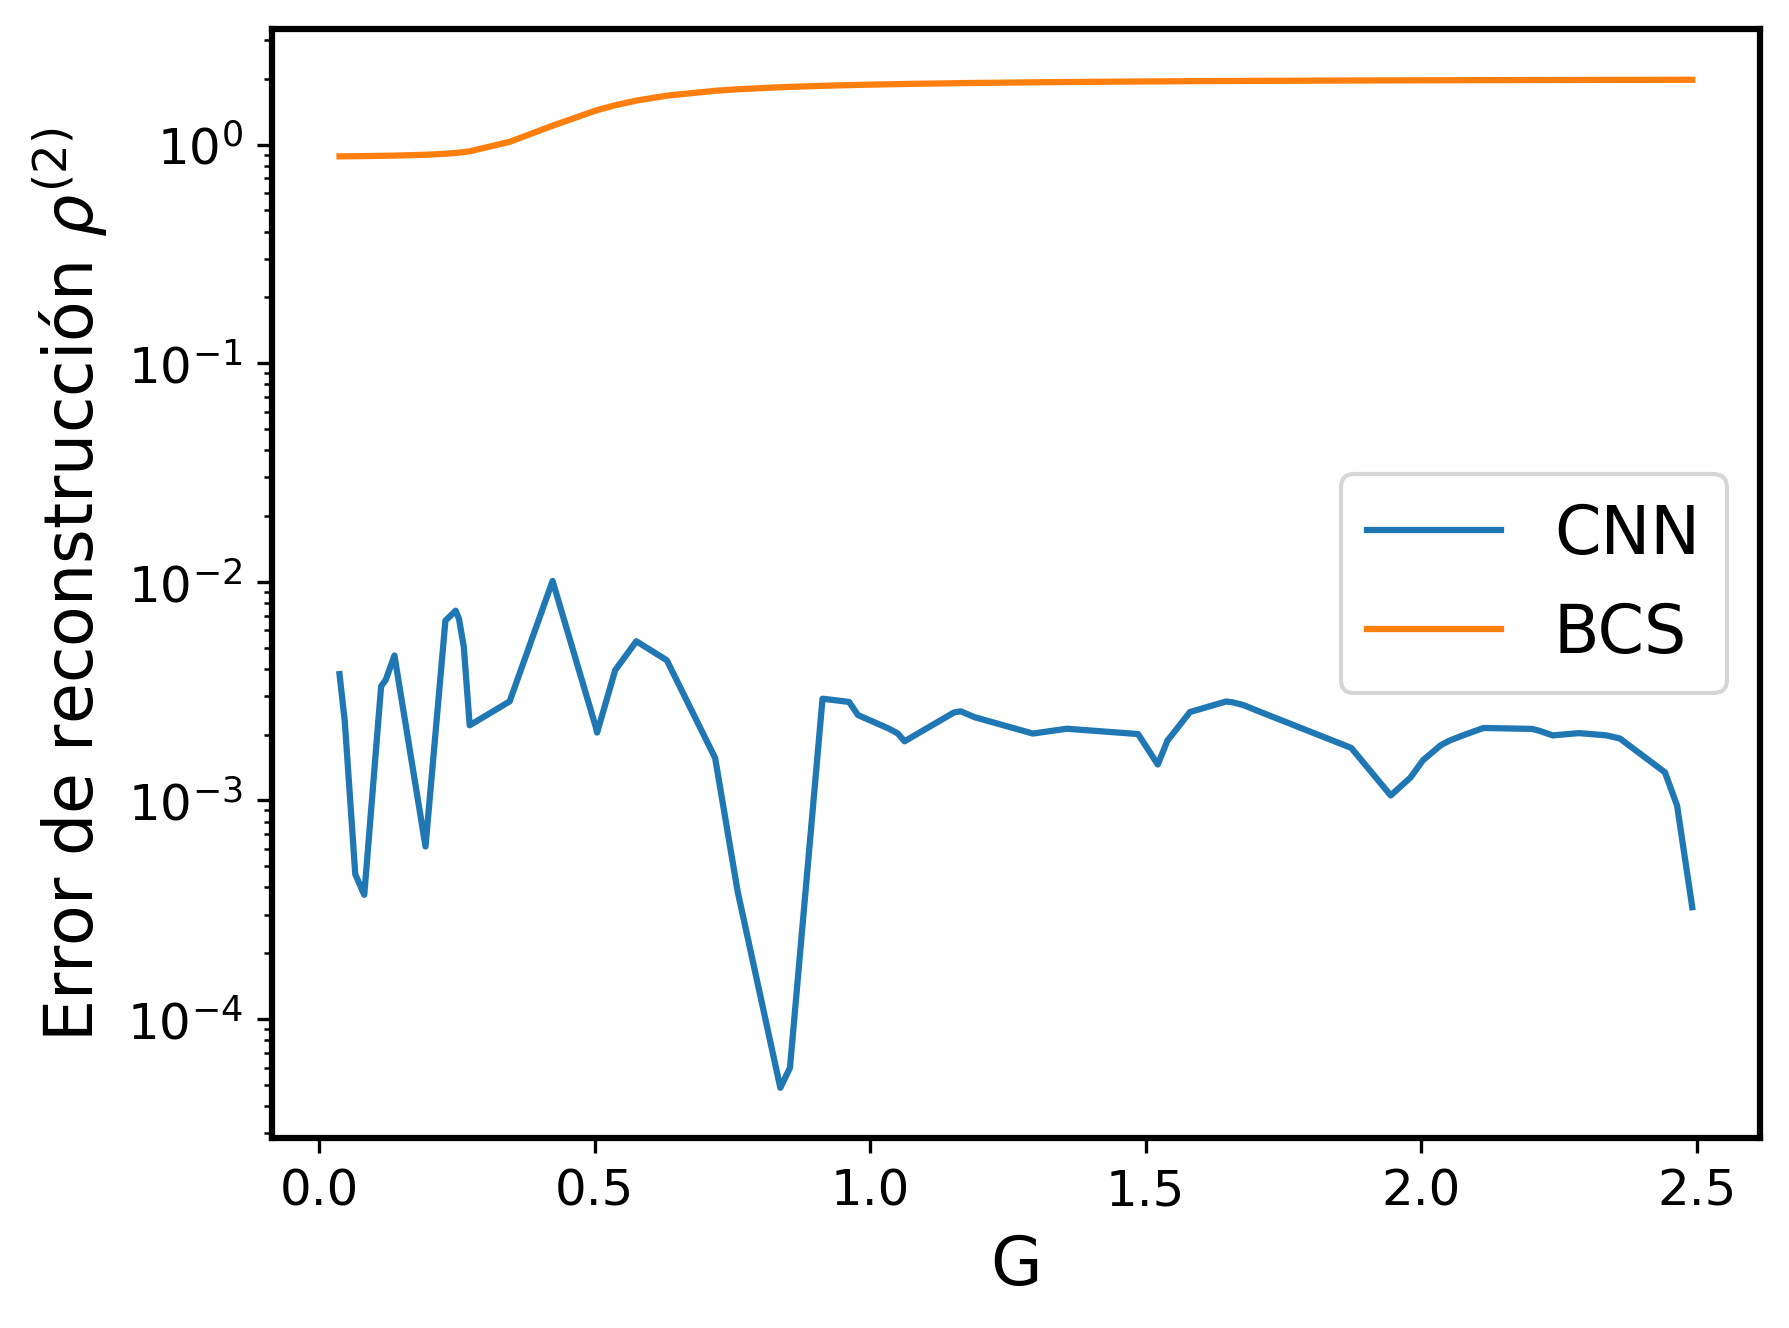

In [ ]:
import numba as nb

en_batch = [np.arange(0, basis.m) - basis.m//2 + 1/2 for _ in range(0,gpu_batch_size)]  # ojo si lo cambie en H
en_batch = tf.constant(en_batch, dtype=tf.float32)

energ = np.array(en_batch[0])
e_mean = np.mean(energ)

# Calcula rho2 ha partir del delta dado, en formato [delta]. Es por el optimize, perdon
@nb.jit(nopython=True)
def bcs_delta(delta: np.ndarray, m = basis.m):
    delta = delta[0]

    lambda_k = lambda k: np.sqrt((energ[k])**2 + delta**2)
    f_k = lambda k: 1/2 * (1 - (energ[k])/lambda_k(k))
    r_k = lambda k: delta/(2*lambda_k(k))

    rho = np.zeros((m, m))
    for k in range(0, m):
        for kp in range(0, m):
            p = f_k(k)**2 if k == kp else 0.0
            rho[k, kp] = r_k(k) * r_k(kp) + p

    return rho


# Calculamos g_BCS a partir de la rho2 calculada por BCS más cercana a rho dada
def g_bcs(rho_init):
    rho_dist = lambda x: np.linalg.norm(bcs_delta(x)-rho_init)
    opti = scipy.optimize.minimize(rho_dist, 1, method='Nelder-Mead')
    delta = opti.x
    lambda_k = lambda k: np.sqrt((en_batch[0][k] - e_mean)**2 + delta**2)
    G = 1/(np.sum([ 1/(2*lambda_k(x)) for x in range(0, basis.m)]))

    return G

# Cargamos elementos del conjunto de validación
iterador = iter(val_dataset)
sample = next(iterador)
input_data = sample[0]
actual_values = sample[1]
predictions = model.predict(input_data)

# Ordenamos los valores de G con el fin de plotear
g_ids = actual_values.numpy().argsort()
predictions_sort = predictions[g_ids]
g_true_sort = actual_values.numpy()[g_ids]

predictions_sort = predictions_sort.T[0]
rho_pred = rho_reconstruction(predictions_sort, h_type, state_type)

# Calculamos ahora G BCS
rho_actual = rho_reconstruction(actual_values.numpy()[g_ids], h_type, state_type)
g_bcs_sort = [g_bcs(x) for x in rho_actual.numpy()]
rho_bcs = rho_reconstruction(g_bcs_sort, h_type, state_type)

rho_error = lambda x: np.linalg.norm(rho_actual.numpy()-x, ord=2, axis=(1,2))

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.dpi'] = 300

plt.plot(g_true_sort, rho_error(rho_pred), label='CNN')
plt.plot(g_true_sort, rho_error(rho_bcs), label='BCS')

plt.yscale("log")
plt.xlabel("G")
plt.ylabel(r"Error de reconstrucción $\rho^{(2)}$")
plt.legend()
plt.show()


In [ ]:
bcs_deltak_rho(delta_r, state_type='thermal'), rho_init
#print(actual_values)
bcs_opti_cost(sample[1][idx], delta_r, h_type='gaussvect', state_type='thermal')

In [ ]:
G = 1
sigma = 2
G * np.exp(-np.arange(basis.m//2)**2/(2 * sigma))

In [ ]:
np.abs([x if x<0 else 0 for x in np.diff(term)])

In [ ]:
auxterm = np.zeros(basis.m)
term = [1,2,3,6,5,6,7,2]
for i in range(0,basis.m-1):
    if term[i] > term[i+1]:
        auxterm[i] = 1
print(auxterm)

##### Caso G = G(k-k')

In [ ]:
# Calcula rho_2 en función del delta_k dado
import scipy.optimize
from sympy import symbols, Function, diff, lambdify
import sympy
import numba as nb

energ = np.array(en_batch[0])
pfact = 2 if h_type == 'vect' else 1

# Dado delta_k simétrico (basis.m//2) devuelve rho asociada
@nb.jit(nopython=True)
def bcs_deltak_rho(delta_k, m = basis.m, state_type = 'gs'):
    delta_k = np.concatenate((delta_k, np.flip(delta_k))) # impongo simetría

    sq = lambda k: np.sqrt(energ[k]**2+delta_k[k]**2)
    vk = lambda k: np.sqrt(1/2 * (1 - energ[k]/sq(k)))
    uk = lambda k: np.sqrt(1/2 * (1 + energ[k]/sq(k)))
    fk = lambda k: 1/(1+np.exp(beta*sq(k))) if state_type == 'thermal' else 0
    ukvk = lambda k: uk(k)*vk(k)*(1-2*fk(k))
    vksq = lambda k: vk(k)**2 * (1-2*fk(k)) + fk(k)

    rho = np.zeros((m, m))
    for k in range(0, m):
        for kp in range(0, m):
            p = vksq(k)**2 if k == kp else 0
            rho[k, kp] = ukvk(k)*ukvk(kp) + p

    return rho

# Pasemos a la inversion, es decir, obtener G(delta_k)

## Metodo exacto (caso vectorial)
### Generamos las funciones para escribir M_ij
def gen_sympy_func(m):
    uv_s = symbols(f'uv0:{m}')
    g_s = symbols(f'g0:{m}')
    d_s = np.zeros(m, dtype=object)
    for i in range(m):
        d_s[i] = np.sum([g_s[np.abs((i-j))//2] * uv_s[j] for j in range(m)])

    funcarr = np.zeros((m//2, m//2), dtype=object)
    for i in range(m//2):
        for j in range(m//2):
            funcarr[i, j] = lambdify(uv_s, diff(d_s[i], g_s[j]), 'numpy')

    return funcarr

M_funcarr = gen_sympy_func(basis.m)

def bcs_build_M(delta_k, m=basis.m):
    delta_k = np.abs(np.concatenate((delta_k, np.flip(delta_k))))
    sq = lambda k: np.sqrt(energ[k]**2+delta_k[k]**2)
    vk = lambda k: np.sqrt(1/2 * (1 - energ[k]/sq(k)))
    uk = lambda k: np.sqrt(1/2 * (1 + energ[k]/sq(k)))
    ukvk = lambda k: uk(k)*vk(k)

    M = np.zeros((m//2, m//2))
    uv_vals = [ukvk(k) for k in range(basis.m)]
    for i in range(m//2):
        for j in range(m//2):
            M[i, j] = M_funcarr[i, j](*uv_vals)

    M = np.linalg.inv(M)
    return M

## Inversion numérica, calculo de la función de costo a partir de autoconsistencia
#@nb.jit(nopython=True)
def bcs_opti_cost(g, delta_k, m=basis.m, state_type='gs', h_type='vect'):
    if h_type == 'gaussvect':
        G, sigma = g[0], g[1] # g = (G, sigma)
        g_s = G * np.exp(-np.arange(m//2)**2/(2 * sigma))
    else:
        g_s = np.insert(g, 0, 0) # nada que hacer en el caso vectorial

    # El choclo es por numba
    delta_k = np.concatenate((delta_k, np.flip(delta_k)))
    sq = lambda k: np.sqrt(energ[k]**2+delta_k[k]**2)
    vk = lambda k: np.sqrt(1/2 * (1 - energ[k]/sq(k)))
    uk = lambda k: np.sqrt(1/2 * (1 + energ[k]/sq(k)))
    fk = lambda k: 1/(1+np.exp(beta*sq(k))) if state_type == 'thermal' else 0
    ukvk = lambda k: uk(k)*vk(k)*(1-2*fk(k))
    vksq = lambda k: vk(k)**2 * (1-2*fk(k)) + fk(k)

    term = np.zeros(m)
    for i in range(m):
        if state_type == 'thermal':
            #term[i] = delta_k[i] - sum([g_s[np.abs((i-j))//2] * delta_k[j] / (2 * sq(j)) * np.tanh(beta * sq(j)/2) for j in range(m)])
            term[i] = delta_k[i] - sum([g_s[np.abs((i-j))//pfact] * ukvk(j) for j in range(m)])
        else:
            term[i] = delta_k[i] - sum([g_s[np.abs((i-j))//2] * ukvk(j) for j in range(m)]) # ojo con un factorcito por aca

    #return term
    return np.linalg.norm(term, ord=2)

# Implementación de la función de inversión mediante ambas estrategias (exacto y numérico)
def bcs_rho_g(rho_init, h_type = 'vect', state_type = 'gs', exact = False, energ_f=0, actual_energy=0, just_delta = False):
    # Buscamos delta_k   TODO: CASO TERMICO ENERGIA
    dist = lambda delta_k: np.linalg.norm(bcs_deltak_rho(delta_k, basis.m, state_type)-rho_init, ord=2) + energ_f * (delta_energ(delta_k, state_type)-actual_energy)**2 + 0 * np.linalg.norm([x if x<0 else 0 for x in np.diff(delta_k)])
    bounds = [(0.01, 100) for _ in range(basis.m//2)] # Bounds de delta_k, TODO determinar o acotar
    opti = scipy.optimize.dual_annealing(dist, bounds=bounds, maxiter=5000)
    #print(opti)
    delta_k = opti.x

    if just_delta:
        return 0, delta_k, opti

    if exact and state_type == 'gs' and h_type == 'vect':
        M = bcs_build_M(delta_k)
        g_rebuild = M @ delta_k[:basis.m//2]
        delta_k = delta_k[:basis.m//2]

    else:
        if h_type == 'gaussvect':
            #g_dist = lambda g: bcs_opti_cost(g, delta_k, basis.m, state_type=state_type, h_type='gaussvect')[:2]
            #optig = scipy.optimize.root(g_dist, np.random.rand(2), method='broyden1', options={'maxiter': 1000})
            #print(optig)
            g_dist = lambda g: bcs_opti_cost(g, delta_k, basis.m, state_type=state_type, h_type='gaussvect')
            bounds = [(g_init, g_stop), (0.01, 2.1)]
            optig = scipy.optimize.dual_annealing(g_dist, bounds=bounds, maxiter=1000)

        else:
            g_dist = lambda g: bcs_opti_cost(g, delta_k, basis.m, state_type=state_type, h_type='vect')
            bounds = [(g_init*5, g_stop*5) for _ in range(basis.m-1)]
            optig = scipy.optimize.dual_annealing(g_dist, bounds=bounds, maxiter=1000)

        #print(optig)
        g_rebuild = optig.x

    return g_rebuild, delta_k, opti

# Calculo de energía en funcion de delta
def delta_energ(delta_k, state_type = 'gs'):
    delta_k = np.concatenate((delta_k, np.flip(delta_k)))
    sq = lambda k: np.sqrt(energ[k]**2+delta_k[k]**2)
    vk = lambda k: np.sqrt(1/2 * (1 - energ[k]/sq(k)))
    uk = lambda k: np.sqrt(1/2 * (1 + energ[k]/sq(k)))
    fk = lambda k: 1/(1+np.exp(beta*sq(k))) if state_type == 'thermal' else 0
    ukvk = lambda k: uk(k)*vk(k)*(1-2*fk(k))
    vksq = lambda k: vk(k)**2 * (1-2*fk(k)) + fk(k)

    h0 = np.sum([2*energ[k]*vksq(k) for k in range(basis.m)])
    hi = np.sum([delta_k[k]**2/(2*sq(k))*(1-2*fk(k)) for k in range(basis.m)])

    return h0 - hi


# Reduce el constraint en energia hasta alcanzar una distancia tolerable en rho
def opti_delta(rho_init, exact, actual_energy, energ_f=0.1):
    max_iter = 1
    tol = 0.2
    dist = lambda delta_k: np.linalg.norm(bcs_deltak_rho(delta_k, basis.m)-rho_init)
    gf, deltaf = np.zeros(basis.m//2), np.zeros(basis.m//2)
    i = 1
    while i < max_iter:
        g, delta, opti = bcs_rho_g(rho_init, exact, energ_f/i, actual_energy=actual_energy) # vamos de a poco reduciendo el constrain en energia
        if dist(delta) < tol:
            gf, deltaf = g, delta
            #print(opti)
            break
        if dist(delta) < dist(deltaf):
            gf, deltaf = g, delta
        i += 1

    return gf, deltaf

# Función auxiliar: calculemos rho2 para esos otros g de la inversion. Recuperamos rho??
def rho_reconstruction_vect(gex):
    return rho_reconstruction([gex], 'vect', state_type)[0]

# Dado delta, obtengo G via la inversión y reconstruyo rho
# delta -> G -> rho_reconstruction_tf
def rho_reconstruction_from_delta(delta_k):
    delta_k = np.abs(np.concatenate((delta_k, np.flip(delta_k))))
    sq = lambda k: np.sqrt(energ[k]**2+delta_k[k]**2)
    vk = lambda k: np.sqrt(1/2 * (1 - energ[k]/sq(k)))
    uk = lambda k: np.sqrt(1/2 * (1 + energ[k]/sq(k)))

    M = bcs_build_M(delta_k[:basis.m//2])
    gex = M @ delta_k[:basis.m//2]

    return rho_reconstruction_vect(gex)

# Calculamos el delta por autoconsitencia
def auto_delta(delta_k, g, m = basis.m, state_type = 'thermal'):
    delta_k = np.concatenate((delta_k, np.flip(delta_k)))
    sq = lambda k: np.sqrt(energ[k]**2+delta_k[k]**2)
    vk = lambda k: np.sqrt(1/2 * (1 - energ[k]/sq(k)))
    uk = lambda k: np.sqrt(1/2 * (1 + energ[k]/sq(k)))
    fk = lambda k: 1/(1+np.exp(beta*sq(k))) if state_type == 'thermal' else 0
    ukvk = lambda k: uk(k)*vk(k)*(1-2*fk(k))
    vksq = lambda k: vk(k)**2 * (1-2*fk(k)) + fk(k)

    gt = g
    term = np.zeros(m//2)
    for i in range(m//2):
        if state_type == 'thermal':
            term[i] = sum([gt[np.abs((i-j))//pfact] * delta_k[j] / (2 * sq(j)) * np.tanh(beta * sq(j)/2) for j in range(m)])
        else:
            term[i] = sum([gt[np.abs((i-j))//pfact] * ukvk(j) for j in range(m)]) # ojo con un factorcito por aca

    return term

In [ ]:
pfact

2

Autoconsistencia

In [ ]:
idx = np.random.randint(0,gpu_batch_size)
idx = 293

# Cargamos los valores
iterador = iter(val_dataset)
sample = next(iterador)
input_data = sample[0][0][idx]
rho_init = input_data
rand_idx = np.random.randint(0,64)
rho_rand = sample[0][0][rand_idx]
actual_energy = sample[0][1][idx]

# Compatibilizamos los dos casos
if h_type == 'gaussvect':
    s = sample[1]
    actual_values = gen_gauss_plus_vect(s[:,0], s[:,1], basis.m)[idx]
    p = model.predict(sample[0])
    prediction = gen_gauss_plus_vect(p[:,0], p[:,1], basis.m)[idx]
elif h_type == 'vect':
    conv = lambda x: np.repeat(np.insert(x,0,0),2)
    actual_values = conv(sample[1][idx])
else:
    actual_values = sample[1][idx]
    prediction = model.predict(sample[0])[idx]

gex = actual_values
delta_r = np.random.rand(basis.m//2)
for k in range(0, 100):
    delta_r = auto_delta(delta_r, gex, state_type=state_type)

dist = lambda delta_k, rho: np.linalg.norm(bcs_deltak_rho(delta_k, basis.m, state_type=state_type)-rho, ord=2) # delta_energ(delta_k)-sample[0][1][0])**2+
#rho_error_from_delta = lambda delta, rho: np.linalg.norm(rho_reconstruction_from_delta(delta) - rho, ord=2)
rho_error_from_ge = lambda ge, rho: np.linalg.norm(rho_reconstruction_vect(ge) - rho, ord=2)

print(np.linalg.norm(rho_init, ord=2)/np.linalg.norm(delta_r, ord=2))
print('>>Autoconsitencia a partir de g true')
print(f'Delta {delta_r}')
print(f'Dist {dist(delta_r, rho_init)} de rho')
print('\n>>Resultados de la inversión')
gex, dex, opti = bcs_rho_g(rho_init, h_type, state_type, exact = False, energ_f=0.01, actual_energy=actual_energy) #energ_f = 0.01
print(gex, dex, opti)
print(np.linalg.norm(rho_init, ord=2)/np.linalg.norm(dex, ord=2))

print(f'Delta {dex}')
print(f'Dist {dist(dex, rho_init)} de rho')
print(f'Energia {delta_energ(dex, state_type=state_type)}')
#print(f'Reconstruccion rho {rho_error_from_delta(dex, rho_init)}')
print('\n>>Valores de G')
print(f'True {sample[1][idx].numpy()}')
print(f'Pred {gex}')
print(f'Energia real {actual_energy}')



5.421359882211557e+153
>>Autoconsitencia a partir de g true
Delta [1.38312866e-154 8.54820525e-155 0.00000000e+000]
Dist 0.8516146540641785 de rho

>>Resultados de la inversión
[ 1.68334474  0.80102762 11.82977332 12.22193049  0.54273601] [0.01 0.01 0.01]  message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 1.593648690054535
       x: [ 1.000e-02  1.000e-02  1.000e-02]
     nit: 5000
    nfev: 46761
    njev: 4189
    nhev: 0
50.893096196954005
Delta [0.01 0.01 0.01]
Dist 0.851613461971283 de rho
Energia -15.391874569536016

>>Valores de G
True [0.0733012  0.05627864]
Pred [ 1.68334474  0.80102762 11.82977332 12.22193049  0.54273601]
Energia real -6.7777279020868715


Dado delta, mejor G?

Version restringida

In [ ]:
def gen_sympy_func(m, label_size, h_type):
    uv_s = symbols(f'uv0:{m}')
    if h_type == 'randomsymm':
        g_s = symbols(f'g0:{label_size}') # gs (semilla)
    else:
        g_s = symbols(f'g0:{label_size + 1}') # debido al 0 inicial

    d_s = np.zeros(m, dtype=object)

    if h_type == 'vectnosymm' or h_type == 'vect':
        for i in range(m):
            d_s[i] = np.sum([g_s[np.abs((i-j))//pfact] * uv_s[j] for j in range(m)])

    elif h_type == 'randomsymm':
        # Generamos la matriz G_kk'
        g_mat = random_fermi_arr_inv(g_s, m, obj = True)
        for i in range(m):
            d_s[i] = np.sum([g_mat[i,j] * uv_s[j] for j in range(m)])

    else:
        raise ValueError

    for i in range(basis.m):
        d_s[i] = d_s[i].subs({g_s[0]:0})

    #return d_s
    funcarr = np.zeros((m, label_size), dtype=object)
    for i in range(m):
        for j in range(label_size):
            funcarr[i, j] = lambdify(uv_s, diff(d_s[i], g_s[j+1]), 'numpy')

    return funcarr

M_funcarr = gen_sympy_func(basis.m, label_size, h_type)

def bcs_build_M_thermal(delta_k, label_size, m=basis.m, state_type = 'thermal'):
    delta_k = np.concatenate((delta_k, np.flip(delta_k)))
    sq = lambda k: np.sqrt(energ[k]**2+delta_k[k]**2)
    vk = lambda k: np.sqrt(1/2 * (1 - energ[k]/sq(k)))
    uk = lambda k: np.sqrt(1/2 * (1 + energ[k]/sq(k)))
    fk = lambda k: 1/(1+np.exp(beta*sq(k))) if state_type == 'thermal' else 0
    ukvk = lambda k: uk(k)*vk(k)*(1-2*fk(k))
    vksq = lambda k: vk(k)**2 * (1-2*fk(k)) + fk(k)

    M = np.zeros((m//2, label_size))
    uv_vals = [ukvk(k) for k in range(m)]
    for i in range(m//2):
        for j in range(label_size):
            M[i, j] = M_funcarr[i, j](*uv_vals)

    return M


Versión libre

In [ ]:
def gen_sympy_func(m, label_size, h_type):
    uv_s = symbols(f'uv0:{m}')
    if h_type == 'randomsymm':
        g_s = symbols(f'g0:{label_size}') # gs (semilla)
    else:
        g_s = symbols(f'g0:{m}') # debido al 0 inicial

    d_s = np.zeros(m, dtype=object)

    if h_type == 'vectnosymm' or h_type == 'vect':
        for i in range(m):
            d_s[i] = np.sum([g_s[np.abs((i-j))] * uv_s[j] for j in range(m)])

    elif h_type == 'randomsymm':
        # Generamos la matriz G_kk'
        g_mat = random_fermi_arr_inv(g_s, m, obj = True)
        for i in range(m):
            d_s[i] = np.sum([g_mat[i,j] * uv_s[j] for j in range(m)])

    else:
        raise ValueError

    #return d_s
    funcarr = np.zeros((m, m), dtype=object)
    for i in range(m):
        for j in range(m):
            funcarr[i, j] = lambdify(uv_s, diff(d_s[i], g_s[j]), 'numpy')

    return funcarr

M_funcarr = gen_sympy_func(basis.m, basis.m, h_type)
#print(M_funcarr)
def bcs_build_M_thermal(delta_k, label_size, m=basis.m, state_type = 'thermal'):
    delta_k = np.concatenate((delta_k, np.flip(delta_k)))
    sq = lambda k: np.sqrt(energ[k]**2+delta_k[k]**2)
    vk = lambda k: np.sqrt(1/2 * (1 - energ[k]/sq(k)))
    uk = lambda k: np.sqrt(1/2 * (1 + energ[k]/sq(k)))
    fk = lambda k: 1/(1+np.exp(beta*sq(k))) if state_type == 'thermal' else 0
    ukvk = lambda k: uk(k)*vk(k)*(1-2*fk(k))
    vksq = lambda k: vk(k)**2 * (1-2*fk(k)) + fk(k)

    M = np.zeros((m//2, m))
    uv_vals = [ukvk(k) for k in range(m)]
    print(uv_vals)
    for i in range(m//2):
        for j in range(m):
            M[i, j] = M_funcarr[i, j](*uv_vals)

    return M


Ahora la idea es hacer todo lo anterior, de manera sistemática

In [ ]:
# TODO Reducir repetición de código con lo anterior

#label_size = 3
idx = 10
# Cargamos valores
val_dataset = dataset.batch(gpu_batch_size*20)
iterador = iter(val_dataset)
sample = next(iterador)
input_data_arr = sample[0][0].numpy()
actual_energy_arr = sample[0][1].numpy()
actual_values_arr = sample[1].numpy()
prediction = model.predict(sample[0])
conv = lambda x: np.repeat(np.insert(x, 0, 0),2) #caso simetrico libre
#conv = lambda x: np.insert(x, 0, 0)
#conv = lambda x: x
conv2 = lambda x: np.insert(x, 0, 0)

def min_opti_g(idx, state_type):
    input_data = input_data_arr[idx]
    rho_init = input_data
    actual_energy = actual_energy_arr[idx]
    #actual_values = conv(actual_values_arr[idx])
    actual_values = actual_values_arr[idx]

    # Calculamos el delta autoconsistente
    gex = conv(actual_values)
    delta_r = np.random.rand(basis.m//2)
    for k in range(0, 100):
        delta_r = auto_delta(delta_r, conv2(actual_values), state_type=state_type)
    #print(delta_r, auto_delta(delta_r, gex))

    # Optimizamos para hallar el delta
    gex, dex, opti = bcs_rho_g(rho_init, h_type, state_type, exact = False, energ_f=0.01, actual_energy=actual_energy, just_delta=True)
    #print(opti)

    delta_o = dex
    print(dex)
    M = bcs_build_M_thermal(delta_o, label_size, state_type = state_type)
    #print(M)
    #print(M.shape, delta_o)
    #print(M @ actual_values)


    eps = 0.1
    lin_const = scipy.optimize.LinearConstraint(M, delta_o-eps, delta_o+eps)
    #cost = lambda g: np.linalg.norm(g-conv(actual_values)) # +np.abs(g[0])
    cost = lambda g: np.linalg.norm(g-conv(actual_values))
    bounds = [(0.01, 100) for _ in range(basis.m)]

    # Exacto (GS)
    #pfact = 2
    #M_funcarr = gen_sympy_func(basis.m, label_size, h_type)
    #M = bcs_build_M_thermal(dex, label_size, basis.m, 'gs')
    #gg = np.linalg.pinv(M) @ dex

    # Nunérico
    opt = scipy.optimize.minimize(cost, np.random.rand(basis.m), constraints=lin_const, bounds=bounds, method='SLSQP')
    gg = opt.x


    #print(opt)
    #print(actual_values)
    #print(M @ opt.x - delta_o)
    return gg, conv(actual_values), conv(prediction[idx]), delta_r


x = min_opti_g(293, 'gs')
x

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[0.40106987 0.04285973 0.15388735]
[0.07920124178485864, 0.008570685604047291, 0.051027950262907906, 0.051027950262907906, 0.04270312476227983, 0.31285613226212244]


(array([0.19471535, 0.02102658, 0.19876206, 0.19878759, 0.16123495,
        0.82560816]),
 array([0.        , 0.        , 0.0733012 , 0.0733012 , 0.05627864,
        0.05627864], dtype=float32),
 array([0.        , 0.        , 0.21084861, 0.21084861, 0.21600889,
        0.21600889], dtype=float32),
 array([0., 0., 0.]))

In [ ]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

min_actual_g = []
min_num_g = []
min_pred_g = []
delta_r_g = []

def task(i):
    return min_opti_g(i, state_type)

with ProcessPoolExecutor() as executor:
    # Submit all the tasks to the executor
    futures = [executor.submit(task, i) for i in range(gpu_batch_size*20)]

    # Use tqdm to display progress
    for future in tqdm(as_completed(futures), total=len(futures)):
        num, actual, pred, delt = future.result()
        min_actual_g.append(actual)
        min_num_g.append(num)
        min_pred_g.append(pred)
        delta_r_g.append(delt)


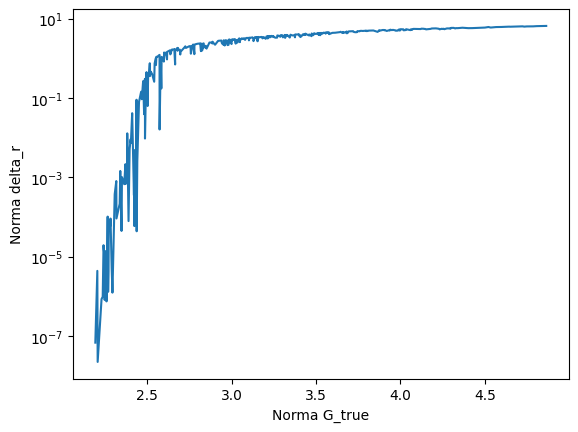

In [ ]:
plt.plot(x[200:], np.linalg.norm(delta_r_g, axis=-1)[sortids][200:])
plt.xlabel("Norma G_true")
plt.ylabel("Norma delta_r")
plt.yscale("log")


(1, 0.01, 2.5), (924, 'thermal')


Text(0, 0.5, 'Norma G_BCS')

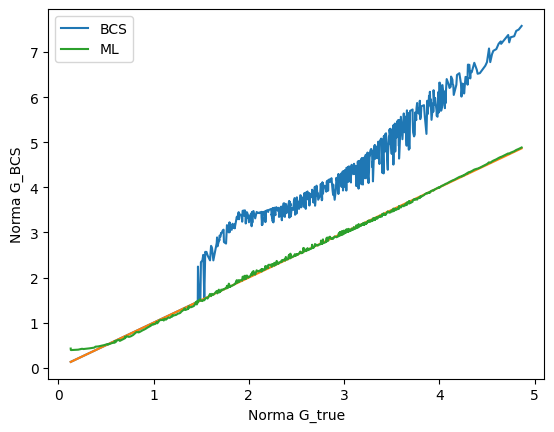

In [ ]:
op = lambda g: [np.linalg.norm(x) for x in g]

for i in range(len(min_actual_g)):
    min_actual_gm = op(min_actual_g)
    min_num_gm = op(min_num_g)
    min_pred_gm = np.array(op(min_pred_g))

sortids = np.array(min_actual_gm).argsort().astype(int)
x = np.array(min_actual_gm)[sortids]
print(f'{beta, g_init, g_stop}, {basis.size, state_type}')
plt.plot(x, np.array(min_num_gm)[sortids], label='BCS')
plt.plot(x, np.array(min_actual_gm)[sortids])
plt.plot(x, min_pred_gm[sortids], label='ML')

#plt.yscale("log")
#plt.ylim(0,5)
plt.legend()
plt.xlabel("Norma G_true")
plt.ylabel("Norma G_BCS")


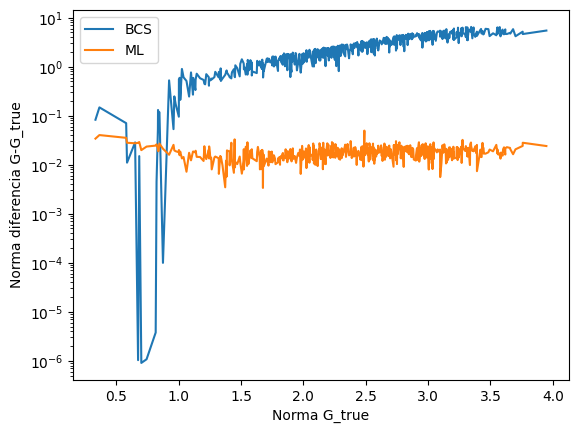

In [ ]:
difop = lambda g: np.linalg.norm(np.array(g)[sortids] - np.array([x for x in min_actual_g])[sortids], axis=-1)
difop2 = lambda g: np.linalg.norm(np.array(g)[sortids] - np.array(min_actual_g)[sortids], axis=-1)

x = np.linalg.norm(min_actual_g, axis=-1)[sortids]
plt.plot(x, difop(min_num_g), label='BCS')
plt.plot(x, difop2(min_pred_g), label='ML')
plt.legend()
plt.xlabel('Norma G_true')
plt.ylabel('Norma diferencia G-G_true')
plt.yscale("log")



#### Caso h_type=randomenerg

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


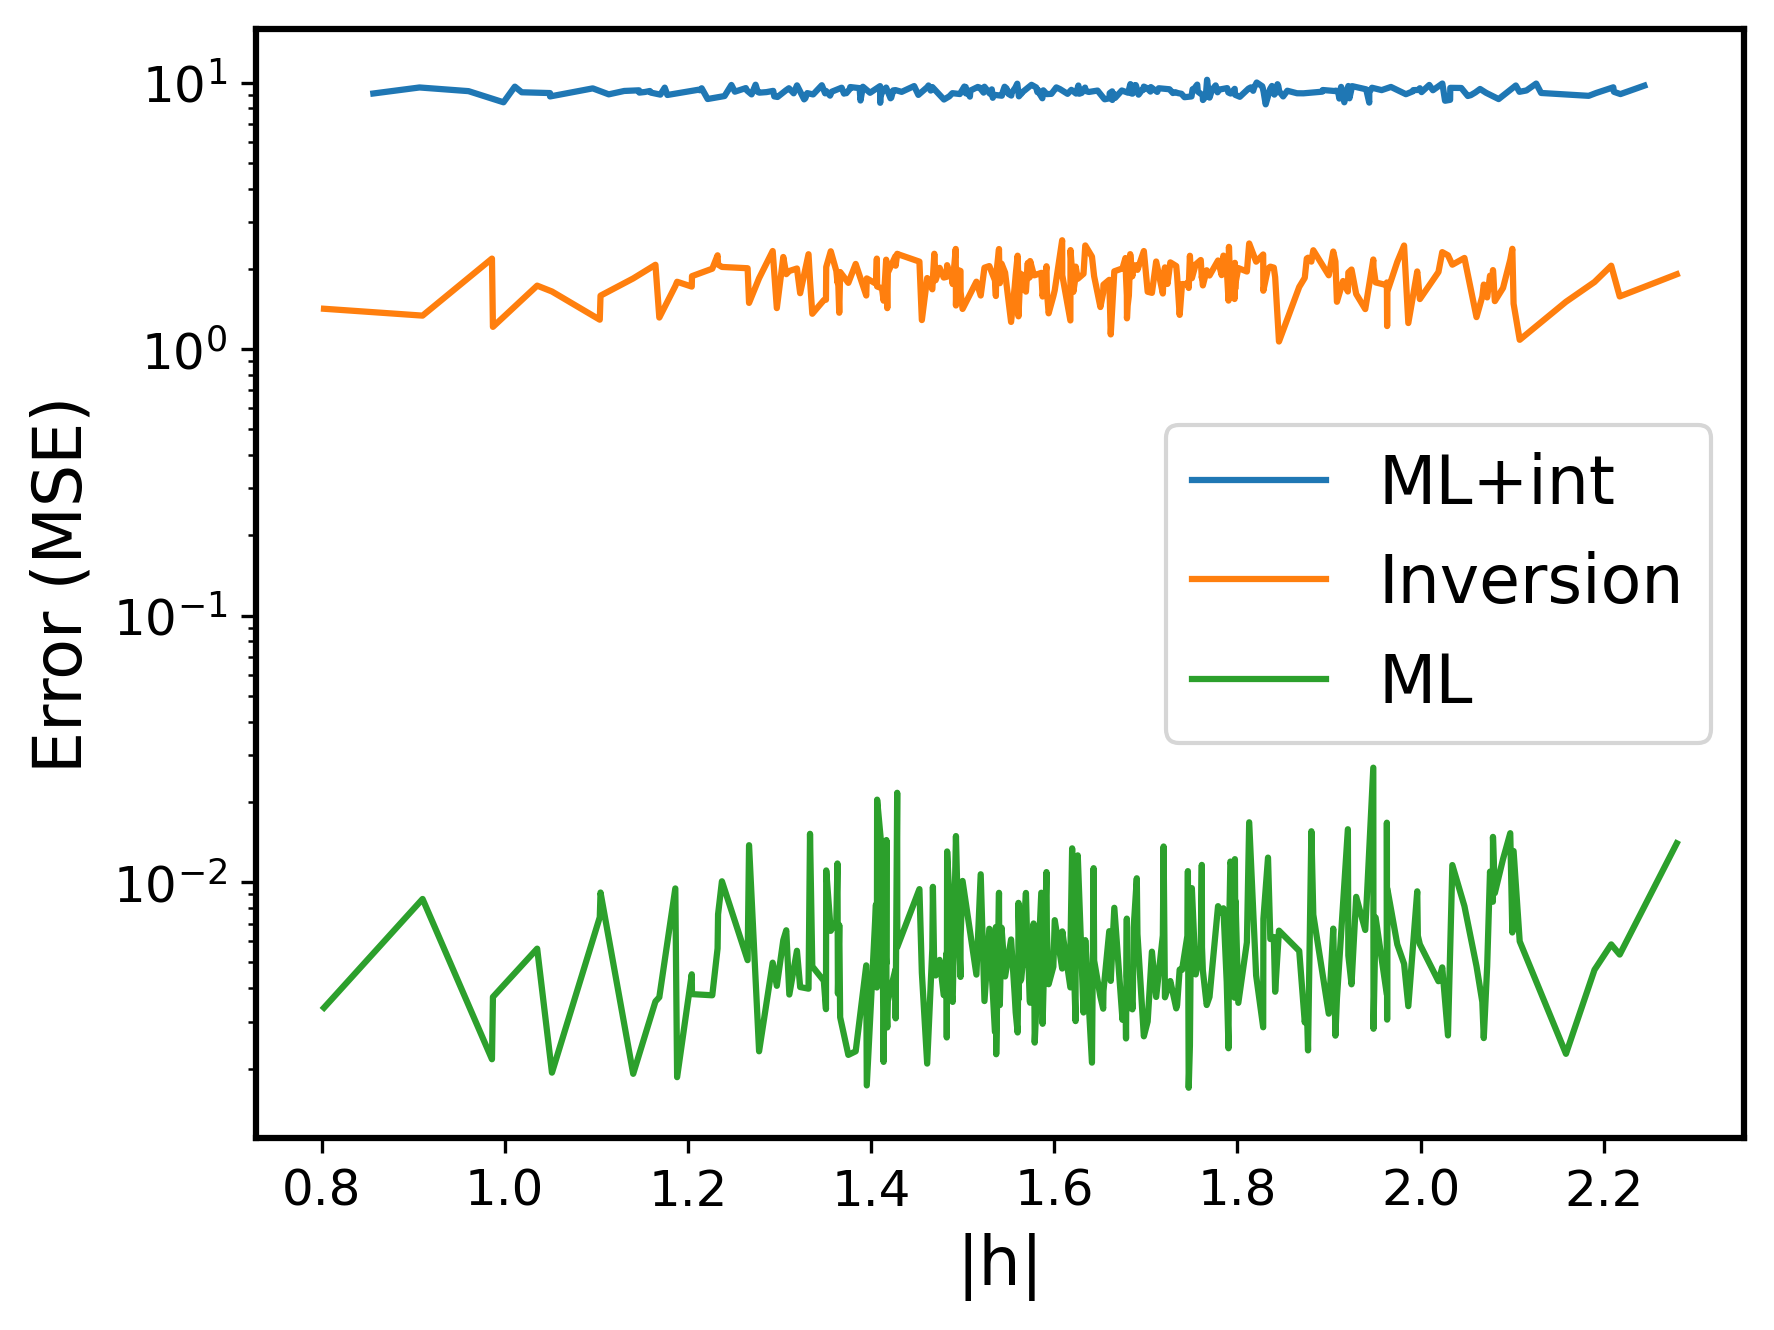

In [ ]:
iterador = iter(val_dataset)
sample = next(iterador)
rho_arr2 = sample[0][0]
prediction2 = model.predict(sample[0])
actual_values2 = sample[1]

sortids2 = np.array(np.linalg.norm(actual_values2, axis=-1)).argsort().astype(int)
x2 = np.array(np.linalg.norm(actual_values2, axis=-1))[sortids2]
actual_values2 = actual_values2.numpy()[sortids2]
ml_arr2 = prediction2[sortids2]

err2 = lambda a: np.linalg.norm(a-actual_values2, axis=-1)
err = lambda a: np.linalg.norm(a-actual_values, axis=-1)

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.dpi'] = 300
plt.xlabel('|h|')
plt.ylabel('Error (MSE)')
plt.yscale('log')
plt.plot(x2, err2(ml_arr2), label='ML+int')
plt.plot(x, err(inv_arr)[sortids], label='Inversion')

plt.plot(x, err(ml_arr), label='ML')

plt.legend()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


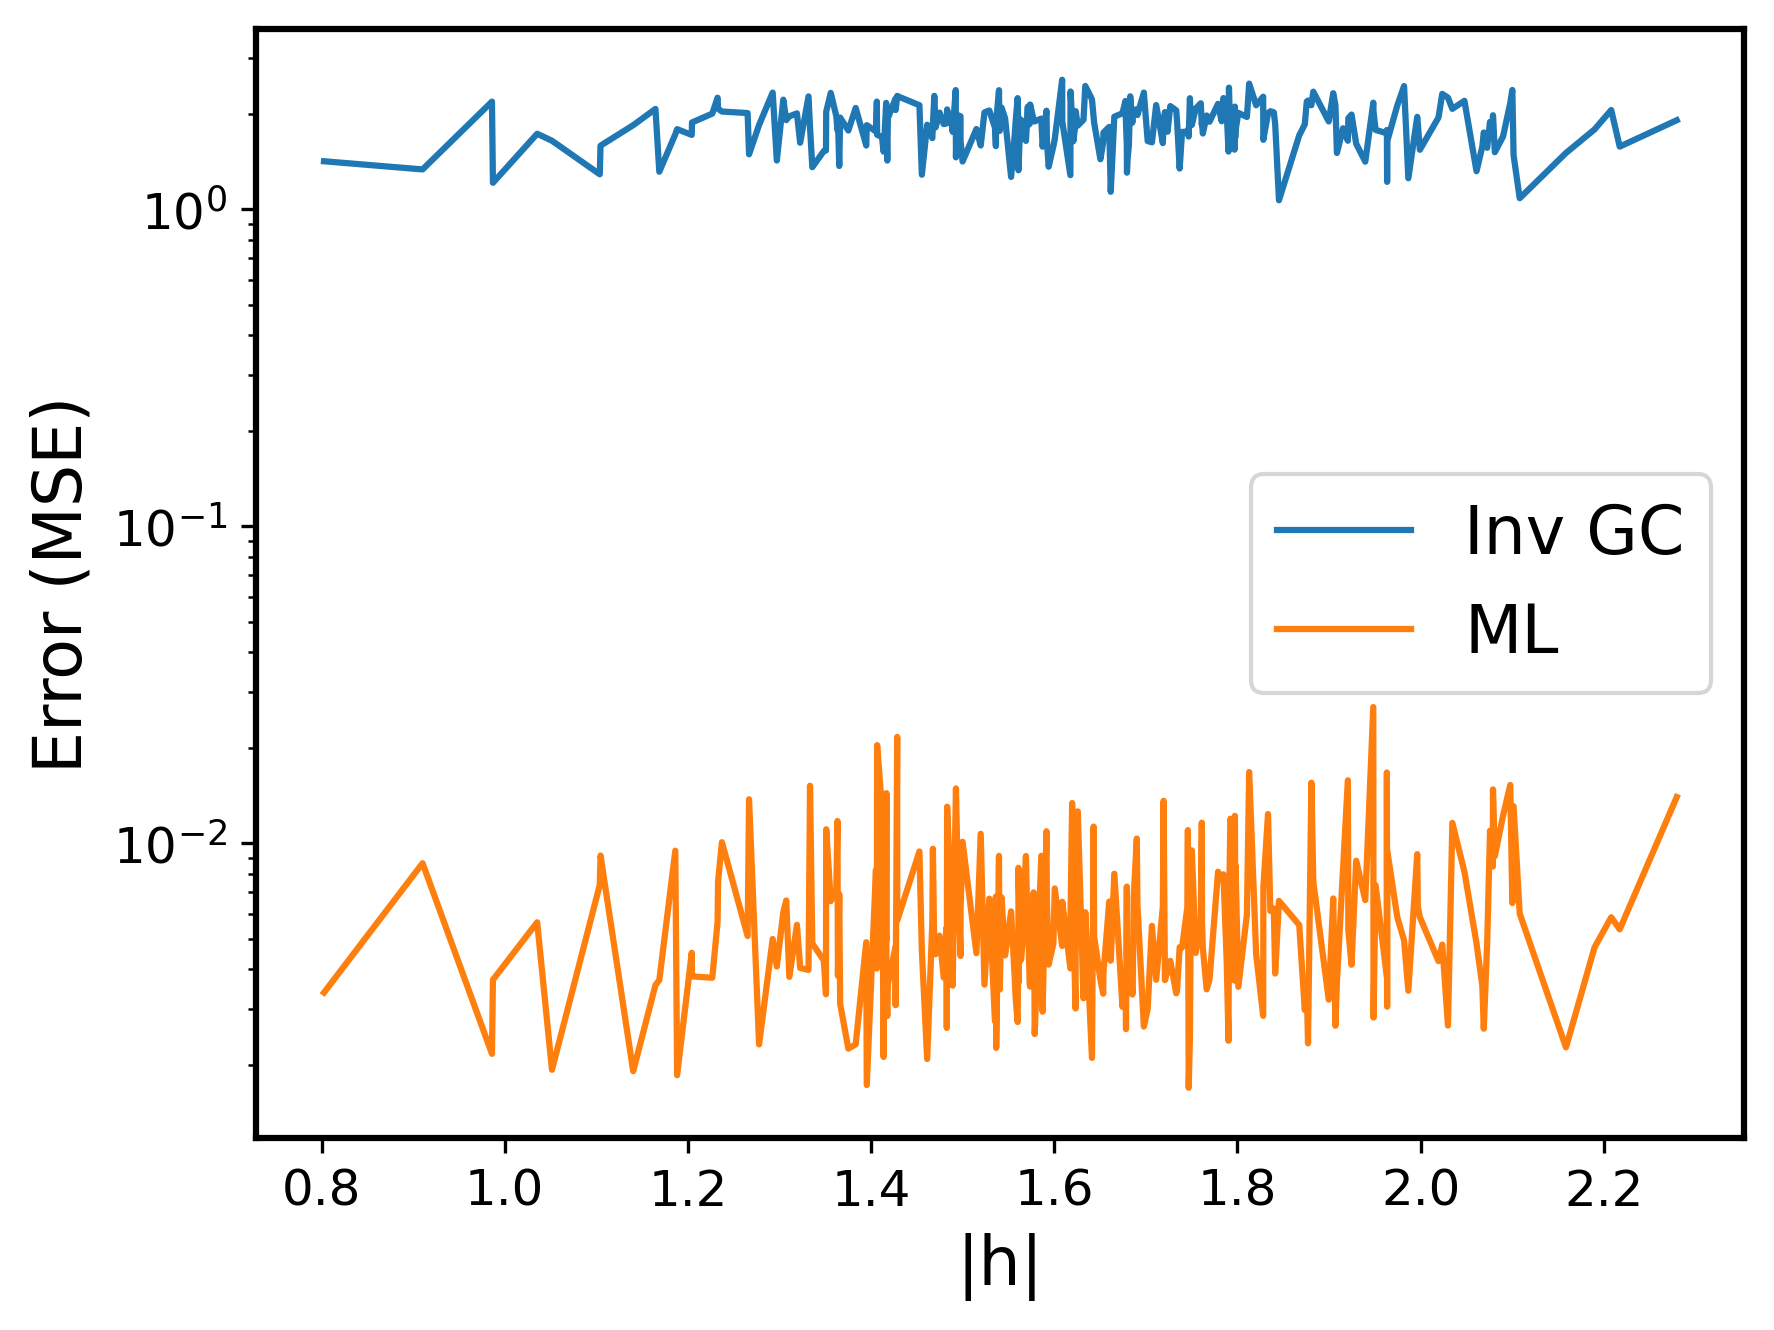

In [ ]:
# Definición de estimadores
def rho1_to_h_gc(rho, beta, mu = 0):
    inv = scipy.linalg.inv(rho)
    mat = scipy.linalg.logm(inv-np.eye(inv.shape[0]))
    return (mat+mu)/beta

idx = np.random.randint(0,100)

iterador = iter(val_dataset)
sample = next(iterador)
rho_arr = sample[0][0]
prediction = model.predict(sample[0])
actual_values = sample[1]

# Ploteamos
## Eje X
sortids = np.array(np.linalg.norm(actual_values, axis=-1)).argsort().astype(int)
x = np.array(np.linalg.norm(actual_values, axis=-1))[sortids]
actual_values = actual_values.numpy()[sortids]

# Gráficos
inv_arr = np.array([np.diagonal(rho1_to_h_gc(r, beta, 0)) for r in rho_arr]).reshape(gpu_batch_size//2,basis.d)
ml_arr = prediction[sortids]
err = lambda a: np.linalg.norm(a-actual_values, axis=-1)

#%matplotlib inline
#plt.rcParams['text.usetex'] = True

plt.plot(x, err(inv_arr)[sortids], label='Inv GC')
plt.plot(x, err(ml_arr), label='ML')
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.dpi'] = 300
plt.legend()
plt.xlabel('|h|')
plt.ylabel('Error (MSE)')
plt.yscale('log')

In [ ]:
for i, x in enumerate(min_actual_gm):
    if np.linalg.norm(x) < 10:
        print(x, min_num_gm[i])

In [ ]:
pre_const = lambda g: bcs_opti_cost_alt(g, dex, basis.m, state_type=state_type, h_type=h_type)
nl_const = scipy.optimize.NonlinearConstraint(pre_const, -0.1, 0.1)
cost = lambda g: np.linalg.norm(g-np.repeat(actual_values,2))
bounds = [(0.1, g_stop+0.5) for _ in range(basis.m)]

#opt = scipy.optimize.minimize(cost, np.random.rand(basis.m), constraints=nl_const, bounds=bounds, method='SLSQP')
opt = scipy.optimize.differential_evolution(cost, bounds=bounds, constraints=nl_const)
print(opt)
print(pre_const(opt.x), actual_values)


In [ ]:
# Buscamos delta_k   TODO: CASO TERMICO ENERGIA
#dist = lambda delta_k: np.linalg.norm(bcs_deltak_rho(delta_k, basis.m, state_type)-rho_init, ord=2) + 0.01 * (delta_energ(delta_k, state_type)-actual_energy)**2
#bounds = [(0, 50) for _ in range(basis.m//2)] # Bounds de delta_k, TODO determinar o acotar
#opti = scipy.optimize.dual_annealing(dist, bounds=bounds, maxiter=1000)
#delta_k = opti.x
#print(delta_k, delta_r)

g_dist = lambda g: bcs_opti_cost(g, delta_r, basis.m, state_type=state_type, h_type='vect')
bounds = [(g_init, g_stop), (0.01, 2.1)]
#optig = scipy.optimize.dual_annealing(g_dist, bounds=bounds, maxiter=1000) broyden1!!
scipy.optimize.root(g_dist, (1,1), method='hybr', options={'maxiter': 10000})

In [ ]:
scipy.optimize.roots

In [ ]:
auto_delta(delta_r, state_type=state_type), delta_r

In [ ]:
g_dist = lambda g: bcs_opti_cost(g, delta_r, basis.m, state_type=state_type, h_type='vect')
bounds = [(g_init, g_stop) for _ in range(basis.m//2)]
optig = scipy.optimize.dual_annealing(g_dist, bounds=bounds, maxiter=1000)
print(optig)
optig.x, sample[1][idx]

In [ ]:
dex, auto_delta(dex, state_type=state_type)

In [ ]:
rbcs = bcs_deltak_rho(dex, state_type=state_type)
np.linalg.eigvals(rbcs), np.linalg.eigvals(rho_init)
plt.plot(np.linalg.eigvals(rbcs))
plt.plot(np.linalg.eigvals(rho_init))
plt.yscale('log')

In [ ]:
nn = [0,1,2,None,np.inf,-1,-2]
for x in nn:
    d = dex
    print(np.linalg.norm(d, ord=x))

print(np.linalg.norm(d, ord=2)*2-np.linalg.norm(d, ord=1))

In [ ]:
bounds = [(0, 50) for _ in range(basis.m//2)]
scipy.optimize.dual_annealing(dist, bounds=bounds, maxiter=10000)

In [ ]:
dist = lambda delta_k: (bcs_deltak_rho(delta_k, basis.m, state_type)-rho_init).numpy().flatten()
op = scipy.optimize.root(dist, np.random.rand(4), method='lm', tol=1e-8, epsfcn = 0.1)
op, delta_r
#delta_k = op.x
#type(dist(delta_r))

In [ ]:
op = scipy.optimize.fsolve(dist, np.random.rand(basis.m//2))
op

In [ ]:
rho_init

In [ ]:
dist = lambda delta_k: np.linalg.norm(bcs_deltak_rho(delta_k, basis.m, state_type)-rho_init)+(np.linalg.norm(delta_k, ord=0)-basis.m//2)**2
bounds = [(0,10) for _ in range(4)]
opti = scipy.optimize.dual_annealing(dist, bounds=bounds, maxiter=10000)
delta_k = opti.x
print(dist(delta_r))

opti, delta_r
#g_dist = lambda g: bcs_opti_cost(g, delta_r, basis.m, state_type=state_type, h_type='gaussvect')
#optig = scipy.optimize.dual_annealing(g_dist, bounds=[(0,10), (0,10)], maxiter=10000)
#optig, sample[1][idx]


In [ ]:
np.linalg.norm(delta_k, ord=0)

In [ ]:
nn = [0,1,2,None,np.inf,-1,-2]
for x in nn:
    print(np.linalg.norm(delta_r, ord=x))

In [ ]:
opti +

In [ ]:
#opti = scipy.optimize.differential_evolution(dist, bounds=bounds)
#opti
opti = scipy.optimize.direct(dist, bounds=bounds, maxiter=1000)
print(dist(delta_r))
opti

In [ ]:
g_dist = lambda g: bcs_opti_cost(g, delta_r, basis.m, state_type=state_type, h_type='gaussvect')
boundss = [(0.01,20) for _ in range(2)]
optig = scipy.optimize.dual_annealing(g_dist, bounds=boundss, maxiter=1000)
sample[1][idx], optig, delta_r


In [ ]:
bcs_opti_cost(sample[1][idx], delta_r, state_type=state_type, h_type='gaussvect')

In [ ]:
g_dist = lambda g: bcs_opti_cost(g, delta_r, basis.m, state_type=state_type, h_type='gaussvect')
opti = scipy.optimize.minimize(g_dist, np.random.rand(2), method='Nelder-Mead', tol=1e-8)
opti, sample[1][idx]

In [ ]:
g_dist(sample[1][rand_idx])

In [ ]:
plt.plot(np.linalg.eigvals(rho_init))

plt.plot(np.linalg.eigvals(bcs_deltak_rho(dex, basis.m)))

In [ ]:
delta_k = dex
# Calculamos el sistema de ecs
delta_k = np.abs(np.concatenate((delta_k, np.flip(delta_k)))) # pues el resultado son los delta indep
sq = lambda k: np.sqrt(energ[k]**2+delta_k[k]**2)
vk = lambda k: np.sqrt(1/2 * (1 - energ[k]/sq(k)))
uk = lambda k: np.sqrt(1/2 * (1 + energ[k]/sq(k)))

M = bcs_build_M(lambda k: uk(k) * vk(k))
M @ delta_k[:basis.m//2]

In [ ]:
arr = []
for i in range(0, 100):
    arr.append(rho_error_from_ge(actual_values.numpy(), sample[0][0][i]))
np.mean(arr)

In [ ]:
rho_init

In [ ]:
maxval = 100
# Cargamos elementos del conjunto de validación
iterador = iter(val_dataset)
sample = next(iterador)

input_rhos = sample[0][0].numpy()[:maxval]
input_energies = sample[0][1].numpy()[:maxval]
actual_values = sample[1].numpy()[:maxval]
input_data = sample[0]
predictions = model.predict(input_data)

# Ordenamos los valores de G con el fin de plotear
g_ids = actual_values[:,0].argsort()
g_ids = np.mean(actual_values, axis=-1).argsort()
predictions_sort = predictions[g_ids]
g_true_sort = actual_values[g_ids]
rho_pred = rho_reconstruction(predictions_sort)
rho_actual = input_rhos[g_ids]

# Calculamos ahora G BCS
rho_bcs_arr = []
for l in tqdm(range(actual_values.shape[0])): # equiv al batch_size
    rho = input_rhos[l]
    actual_energy = input_energies[l]
    gex, dex = opti_delta(rho, actual_energy,0)
    rho_bcs = rho_reconstruction(gex)
    #print(rho_bcs)
    rho_bcs_arr.append(rho_bcs)

rho_bcs = np.array(rho_bcs_arr)[g_ids]

rho_error = lambda x: np.linalg.norm(rho_actual-x, ord='fro', axis=(1,2))

plt.plot(g_true_sort[:,0], rho_error(rho_pred), label='DNN prediction') # ploteamos segun el primero
plt.plot(g_true_sort[:,0], rho_error(rho_bcs), label='BCS')
plt.yscale("log")
plt.xlabel("g")
plt.ylabel("Rho2 reconstruction error")
plt.legend()
plt.show()

In [ ]:
plt.plot(np.sort(np.mean(actual_values, axis=-1)), rho_error(rho_pred), label='CNN prediction') # ploteamos segun el primero
plt.plot(np.sort(np.mean(actual_values, axis=-1)), rho_error(rho_bcs), label='BCS')
plt.yscale("log")
plt.xlabel("g")
plt.ylabel("Rho2 reconstruction error")
plt.legend()
plt.show()

In [ ]:
rho_error = lambda x: np.linalg.norm(rho_actual-x, ord=2, axis=(1,2))

plt.plot(g_true_sort[:,0], rho_error(rho_pred), label='DNN prediction') # ploteamos segun el primero
plt.plot(g_true_sort[:,0], rho_error(rho_bcs), label='BCS')
plt.yscale("log")
plt.xlabel("g")
plt.ylabel("Rho2 reconstruction error")
plt.legend()
plt.show()

#### Análisis para G cte

In [ ]:
# Generacion de elementos, rho2 a partir de ellos, y comparación con la predicción
# Nuevamente, el resultado depende pura y exclusivamente del modelo, y no de los ptos tomados
h_labels = np.linspace(0.1,1,512)
g_arr = [np.ones((basis.m, basis.m))*g_seed for g_seed in h_labels]
g_arr = tf.constant(g_arr, dtype=tf.float32)
h_arr = two_body_hamiltonian_tf(t_basis, basis.m, en_batch, g_arr.numpy(), rho_1_arrays, rho_2_arrays, k_indices_tf)

# Estados térmicos
state = thermal_state_tf(h_arr*beta)
state = tf.cast(state, dtype=tf.float32)
# Estados puros
#state = pure_state(h_arr)

rho_2_input = rho_2_tf(state, rho_2_arrays_kkbar_tf)
predictions = model.predict(rho_2_input).T
G_err = np.abs(predictions-h_labels).T
plt.plot(h_labels, G_err)

In [ ]:
# Ploteo de varios elementos de val_dataset
# No sirve de mucho, depende del modelo y no la muestra
max_plt = 10
idx = 0
for e in val_dataset:
    predictions = model.predict(e[0])
    pred_ids = predictions.T.argsort()
    predictions_sort = predictions[pred_ids][0]
    G_true_sorted = e[1].numpy()[pred_ids].T
    G_err = np.abs(predictions_sort-G_true_sorted)
    plt.plot(predictions_sort,G_err)
    idx += 1
    if idx > max_plt:
        break


## Modelos Random Forest

Tenemos que trabajar con DataFrames para trabajar con xgboost, por eso inicialmente desempaquetamos el dataset

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow_decision_forests as tfdf
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np


def rf_fit(dataset):
    # Generación de dataset
    ds_f = {} # features
    ds_l = {} # labels

    # Generamos las etiquetas
    for i in range(basis.m*basis.m):
        ds_f[f'{i}'] = []
    # Generacion de labels TODO: Escribir todo en función del label size y fue
    if label_size == 1:
        ds_l['g'] = []
    elif label_size == 2:
        ds_l['g'] = []
        ds_l['sigma'] = []
    else:
        for i in range(0, label_size):
            ds_l[f'l{i}'] = []

    # Poblamos el DF
    for e in list(dataset.as_numpy_iterator()):
        # Elementos de rho2
        for i in range(0,basis.m*basis.m):
            ds_f[f'{i}'].append(np.ndarray.flatten(e[0])[i])
        # Labels
        if label_size == 1:
            ds_l['g'].append(e[1])
        elif label_size == 2:
            ds_l['g'].append(e[1][0])
            ds_l['sigma'].append(e[1][1])
        else:
            for i in range(0, label_size):
                ds_l[f'l{i}'].append(e[1][i])

    ds_l = pd.DataFrame(ds_l)
    ds_f = pd.DataFrame(ds_f)

    # Spliteamos los datasets
    X_train, X_test, y_train, y_test = train_test_split(ds_f, ds_l, test_size=0.2, random_state=42)

    # Entrenamos
    regressor = xgb.XGBRegressor(objective='reg:squarederror', max_depth=20)
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)

    # Evaluamos
    mse = mean_squared_error(y_test, predictions)
    print(f'Mean Squared Error: {mse}')

    return regressor, X_test, y_test, y_train


Análicemos los resultados

In [ ]:
def rf_error_coef(regressor, X_test, y_test, y_train):
    predictions = regressor.predict(X_test)
    # Printeamos algunos valores
    for i in range(0, 10):
        print(predictions[i], y_test.to_numpy()[i])

    if label_size == 1:
        actual_values = y_test.to_numpy()
        norm_pred = np.mean(np.abs(predictions-actual_values.T))
        norm_rand = np.mean(np.abs(y_train.to_numpy()[:len(actual_values)]-actual_values))
    elif label_size > 1:
        norm_pred = np.mean(np.linalg.norm(predictions-y_test.to_numpy(),ord=2, axis=1))
        norm_rand = np.mean(np.linalg.norm(y_train.to_numpy()[:len(predictions)]-y_test.to_numpy(),ord=2, axis=1))

    print(norm_pred, norm_rand)
    print(norm_rand / norm_pred)
    return norm_rand / norm_pred

# Análisis

Ejemplo de uso

In [ ]:
dataset, label_size = gen_dataset('const', 0.1, 5, 'thermal', 'rho1')
# DNN
#model, val_dataset = dnn_fit(dataset, label_size)
#dnn_error_coef(model, val_dataset)
# RF
regressor, X_test, y_test, y_train = rf_fit(dataset)
rf_error_coef(regressor, X_test, y_test, y_train)

In [ ]:
# Barrido en intervalos de G para G cte
g_init_range = np.linspace(0.01,10,20)
err_arr = []
for g_init in g_init_range:
    print(g_init)
    dataset, label_size, input_type = gen_dataset('const', g_init, g_init+0.5, 'gs', 'rho1')
    # DNN
    model, val_dataset, history = dnn_fit(dataset, label_size, input_type)
    err = dnn_error_coef(model, val_dataset)
    # RF
    #regressor, X_test, y_test, y_train = rf_fit(dataset)
    #err = rf_error_coef(regressor, X_test, y_test, y_train)
    err_arr.append(err)

plt.plot(g_init_range,err_arr)

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel('G init')
plt.ylabel('Loss coef')
plt.plot(g_init_range,err_arr)

# Misc

In [ ]:
from xgboost import plot_tree
import matplotlib
xgb.plot_tree(regressor, num_trees=20)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')


In [ ]:
# Para G cte, error en función de G. Sí, es cualquier cosa
import matplotlib.pyplot as plt

pred_ids = predictions.T.argsort()
predictions_sort = predictions[pred_ids]
G_true_sorted = y_test.to_numpy()[pred_ids].T[0]
G_err = np.abs(predictions_sort-G_true_sorted)
plt.plot(predictions_sort,G_err)

In [ ]:
# Spliteo de DataFrames y generacion de Datasets
label = 'h_labels'

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)

# Entrenamiento
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
model.compile(metrics=["mse"])
model.fit(x=train_ds)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
model.compile(metrics=["mse"])
evaluation = model.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

predictions = model.predict(test_ds)

for e in test_ds:
    for i in range(0, 10):
        print(e[1][i])
        print(predictions[i])
    break


In [ ]:
import matplotlib.pyplot as plt
logs = model.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

Testeo barrido en G código anterior

In [ ]:
num = 100
g_range = np.linspace(0.01,20,num)
rho_range= {}
gpu_batch_size = 2

# Construccion de parametros y matrices auxiliares
#rho1_size = m1_basis.size
rho2_size = m2_basis.size
rho2kkbar_size = basis.m
fund_size = basis.size
hamil_base_size = basis.d*(basis.d+1)//2
rho_1_arrays = rho_1_gen(basis)
rho_1_arrays_tf = tf.constant(rho_1_arrays, dtype=tf.float32)
rho_2_arrays = rho_2_gen(basis, nm2_basis, m2_basis)
rho_2_arrays_tf = tf.constant(rho_2_arrays, dtype=tf.float32)
rho_2_arrays_kkbar = rho_2_kkbar_gen(t_basis, rho_2_arrays)
rho_2_arrays_kkbar_tf = tf.constant(rho_2_arrays_kkbar, dtype=tf.float32)
k_indices = get_kkbar_indices(t_basis)
k_indices_tf = gen_update_indices(t_basis, gpu_batch_size)

batch_size = 2
indices = tf.constant(get_kkbar_indices(t_basis))
indices_tf = gen_update_indices(t_basis, batch_size)
en_batch = [np.arange(0, basis.m) for _ in range(0,batch_size)]
en_batch = tf.cast(en_batch, dtype=tf.float32)
G_batched = [np.ones((basis.m,basis.m)) for _ in range(0, batch_size)]

#h_arr = two_body_hamiltonian_tf(t_basis, basis.m, en_batch, g_arr.numpy(), rho_1_arrays, rho_2_arrays, k_indices_tf)
#(h0, hi) = (t[0][0].numpy(), t[1][0].numpy())



In [ ]:
fund = [np.linalg.eigh(h[k,:,:])[1][:,0] for k in range(gpu_batch_size)]
for x in range(gpu_batch_size):
    fund_arr = np.array([np.outer(v,v) for v in fund])

fund_arr[0]

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [ ]:

en_batch = [np.repeat(np.arange(0, basis.num) - basis.num//2 + 1/2, 2) for _ in range(0,gpu_batch_size)] # Semilla para H equiespaciado
energy_seed = en_batch
#print(g)
## CONST
G_batched = [g * np.ones((basis.num,basis.num)) for _ in range(0, gpu_batch_size)]

h = two_body_hamiltonian_sp(energy_seed, G_batched, rho_1_arrays, rho_2_arrays, get_kkbar_indices(t_basis))
h = h.todense()
fund = [np.linalg.eigh(h[k,:,:])[1][:,0] for k in range(gpu_batch_size)]
for x in range(gpu_batch_size):
    fund_arr = np.array([np.outer(v,v) for v in fund])

print(fund_arr[0])
print(fund_arr.shape, rho_2_arrays.shape)
np.einsum('bkl,ijkl->bij', fund_arr, rho_2_arrays)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]
(2, 6, 6) (4, 4, 6, 6)


Format,coo
Data Type,float64
Shape,"(2, 4, 4)"
nnz,4
Density,0.125
Read-only,True
Size,128
Storage ratio,0.50


In [ ]:
gpu_batch_size = 2
def compute_g(g):
    en_batch = [np.repeat(np.arange(0, basis.num) - basis.num//2 + 1/2, 2) for _ in range(0,gpu_batch_size)] # Semilla para H equiespaciado
    energy_seed = en_batch
    #print(g)
    ## CONST
    G_batched = [g * np.ones((basis.num,basis.num)) for _ in range(0, gpu_batch_size)]
    #G_batched = [g * np.ones(t_basis.size * (t_basis.size + 1)//2) for _ in range(0, gpu_batch_size)]
    h = two_body_hamiltonian_sp(energy_seed, G_batched, rho_1_arrays, rho_2_arrays, get_kkbar_indices(t_basis))
    #h = two_body_hamiltonian_sp(energy_seed, G_batched, rho_1_arrays, rho_2_arrays)
    print(h.shape)
    h = h.todense()
    fund = [np.linalg.eigh(h[k,:,:])[1][:,0] for k in range(gpu_batch_size)]
    for x in range(gpu_batch_size):
        fund_arr = np.array([np.outer(v,v) for v in fund])
    print(fund_arr.shape)
    #print(fund)
    #print('rho')
    #Toda la matriz
    rho = rho_2(fund_arr, rho_2_arrays)[0]
    #Solo el bloque kkbar
    #rho = rho_2_kkbar(basis, fund, ml_basis, mll_basis, t_basis)
    #Rho1
    #rho = rho_1(basis, fund).todense()
    r = np.sort(np.linalg.eigvals(rho.todense()).real)
    #print(r)
    return (g, r)

# Version sincrónica
rho_range = {}
g_range = np.linspace(0,5,10)

for g in g_range:
    print(g)
    rho_range[g] = compute_g(g)


0.0
(2, 6, 6)
(2, 6, 6)
0.5555555555555556
(2, 6, 6)
(2, 6, 6)
1.1111111111111112
(2, 6, 6)
(2, 6, 6)
1.6666666666666667
(2, 6, 6)
(2, 6, 6)
2.2222222222222223
(2, 6, 6)
(2, 6, 6)
2.7777777777777777
(2, 6, 6)
(2, 6, 6)
3.3333333333333335
(2, 6, 6)
(2, 6, 6)
3.8888888888888893
(2, 6, 6)
(2, 6, 6)
4.444444444444445
(2, 6, 6)
(2, 6, 6)
5.0
(2, 6, 6)
(2, 6, 6)


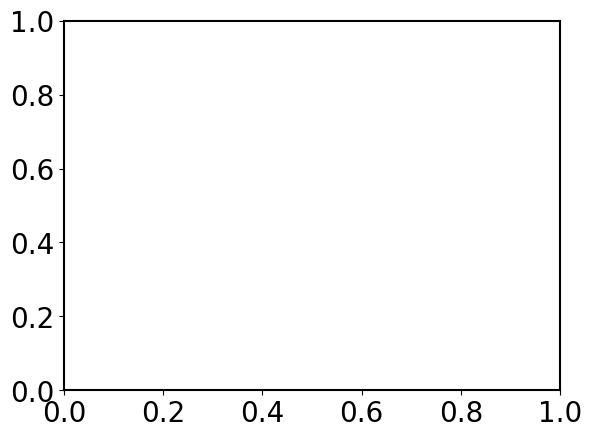

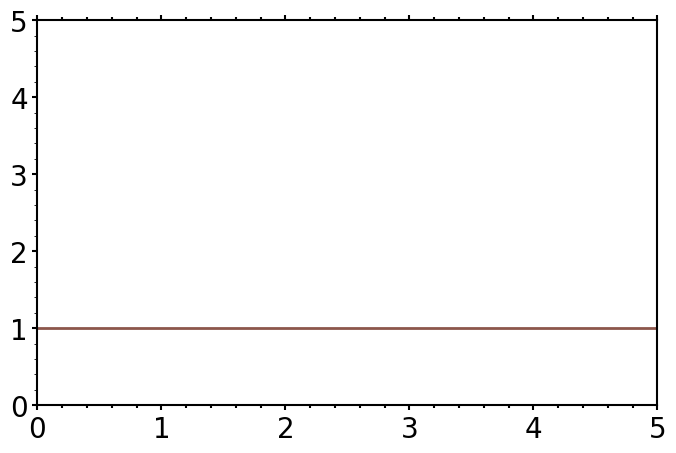

In [ ]:
# Ploteamos
rho_range = dict(rho_range)
rho_range = dict(sorted(rho_range.items()))
x_axis = list(g_range)
values = list(rho_range.items())
size = len(values[0][1])
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
num = 10
# Plot using matplotlib
# Use LaTeX to format all text

plt.rcParams['text.usetex'] = False #True
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['axes.linewidth'] = 1.5

plt.cla()
plt.figure(figsize=(8, 5))
#%matplotlib qt
%matplotlib inline
for k in range(1,size):
    plt.plot(x_axis, [values[j][1][k] for j in range(0,num)], linewidth=2)

#plt.xlabel(r'$G/\epsilon$', fontsize=18)
#plt.ylabel(r'$\lambda^{(2)}$', fontsize=18)
plt.xlim(0, 5)  # Set x-axis limits from 0 to 6
plt.ylim(0, 5)  # Set y-axis limits from 5 to 12

#matplotlib.use('Agg')
#matplotlib.use('GTK3Agg')

plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True)

# Enable minor ticks on the x-axis
plt.minorticks_on()

# Customize the appearance of minor ticks on the x-axis
plt.tick_params(axis='x', which='minor', width=1.5)
plt.tick_params(axis='x', which='major', width=1.5)
plt.tick_params(axis='y', which='major', width=1.5)

plt.show()
#matplotlib.pyplot.savefig('filename.png')
